# Regime Switching Models for High‑Frequency Quotes
## Markov Chains, Hidden Markov Models, Change‑Point Detection, and Quantitative Finance Applications

Financial markets rarely behave as a single, time‑homogeneous stochastic process. Even within a single trading day, the joint behavior of volatility, liquidity, and order‑book activity often alternates between persistent modes: calm vs. stressed, liquid vs. thin, orderly vs. jumpy.

Regime‑switching models formalize this observation by introducing a *latent discrete state* that governs the distributional properties of observable market features. In modern quantitative work, these models serve two distinct purposes:

1. Descriptive segmentation (offline): identify and characterize market conditions over a historical sample.
2. Operational monitoring (online): maintain real‑time probabilities of stress/liquidity regimes for risk and execution controls.

A central theme throughout is the distinction between:

- Filtering (online, causal):  
  $$
  p(s_t \mid x_{1:t})
  $$
- Smoothing (offline, non‑causal):  
  $$
  p(s_t \mid x_{1:T})
  $$

Filtering is the object you can use in production decision rules without look‑ahead; smoothing is the object you use to interpret and diagnose regimes after the fact.



## Roadmap

We proceed in a deliberately structured progression:

0. From irregular quote updates to a regular time grid (feature engineering)
1. Regime persistence as a probabilistic hypothesis
2. Markov chains: persistence, transition matrices, and geometric durations
3. Hidden Markov Models (HMMs): latent states with probabilistic emissions
4. Emission likelihoods and numerical stability (log space)
5. Forward–Backward: filtering vs smoothing
6. Baum–Welch (EM): maximum‑likelihood estimation for HMMs
7. Viterbi: hard decoding vs posterior probabilities
8. Regime switching vs change‑point detection
9. Bayesian regularization: “sticky” transitions and BOCPD
10. Duration modeling: HSMM perspective
11. Covariate‑driven transitions: a pragmatic diagnostic
12. Finance applications: risk and execution diagnostics from quotes‑only regimes

## Data context: top‑of‑book quotes and why we time‑bin

Quote updates arrive at irregular times $\tau_n$. Let the top‑of‑book state be
$$
q(\tau_n) = \big(b(\tau_n), a(\tau_n), B(\tau_n), A(\tau_n)\big),
$$
where $b,a$ are bid/ask prices and $B,A$ are bid/ask sizes at the best level.

Regime models in this chapter will be **discrete‑time**. We therefore define a regular grid
$$
t_k = t_0 + k\Delta,\qquad k=1,2,\dots
$$
and summarize the event‑time stream into bar‑level features $x_{t_k}$.

A common, economically defensible choice for quotes is last observation carried forward (LOCF) within each bin: the market is treated as persisting at its most recent quoted state until a new quote arrives.

Using a **right‑edge convention**, the bar timestamp $t_k$ represents the time at which the information in the bin $(t_k-\Delta,\,t_k]$ becomes available.

 
## Feature definitions

On the grid $t_k$, we use features designed to proxy economically meaningful “market state” components:

- **Mid price**: $\;m_{t_k} = \tfrac{1}{2}(a_{t_k}+b_{t_k})$
- **Log mid**: $\;\log m_{t_k}$, **log return**: $\;r_{t_k} = \log m_{t_k} - \log m_{t_{k-1}}$
- **Spread (bps)**: $\;10^4\frac{a_{t_k}-b_{t_k}}{m_{t_k}}$
- **Top‑of‑book depth**: $\;D_{t_k} = A_{t_k}+B_{t_k}$
- **Imbalance**:
$$
  I_{t_k}=\frac{B_{t_k}-A_{t_k}}{A_{t_k}+B_{t_k}}\in[-1,1]
$$
- **Quote intensity**: $N_{t_k}$ = number of quote updates inside the bin
- **Microprice** (informative in some microstructure settings):
$$
  \text{micro}_{t_k}=\frac{a_{t_k}B_{t_k}+b_{t_k}A_{t_k}}{A_{t_k}+B_{t_k}}
$$

These are not the only choices; they are selected because they align with state variables quants care about:
**volatility**, **transaction cost proxies**, **available liquidity**, and **activity**.


# 0. Setup and data pipeline: from event time to regular time bars

Before any regime model can be estimated, we must specify what a "time step" means.

In a Markov or hidden Markov model, the transition matrix $A$ and the state durations are defined relative to the sampling scheme. A "sticky" regime at a 1-second grid may look far less sticky at a 1-minute grid. This is not a flaw of the model; it is a property of the discretization.

We will:

1. Stream daily quote CSV files into regular time bars at a base frequency $\Delta$.
2. Compute robust microstructure features suitable for Gaussian emissions.
3. Resample to coarser grids for methods that benefit from stronger signal-to-noise.

Throughout we enforce a right-edge timestamp convention: a bar labeled $t$ summarizes $(t-\Delta,\, t]$ and becomes usable at time $t$.

In [25]:
import os
import glob
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from IPython.display import display

# --- Notebook Display Settings ---
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

# --- Data Configuration ---
DATA_DIR = "tardis_binance_btc"
SYMBOL = "BTCUSDT"
EXCHANGE_PREFIX = "binance-futures" 

# 'timestamp' = exchange; 'local_timestamp' = receipt time
TIMESTAMP_COL = "timestamp"

# --- Sampling Frequencies ---
BASE_FREQ = "1s"    # Raw feature resolution
HMM_FREQ = "5s"     # Resampled for model stability/speed
CPD_FREQ = "1min"   # Change-point detection window

# --- Performance/IO Settings ---
MAX_FILES = None    # Set integer to throttle data load for local dev
CHUNKSIZE = 2_000_000
USE_CACHE = True
CACHE_PATH = f"cache_quotes_bars_{SYMBOL}_{BASE_FREQ}.pkl"

# --- Reproducibility ---
SEED = 7
rng = np.random.default_rng(SEED)

# --- Feature Engineering Params ---
RV_LOOKBACK_BARS = 60

# --- Outlier Mitigation ---
# Gaussian emissions are sensitive to heavy tails. We clip and scale 
# to prevent "one-bar regimes" triggered by microstructure spikes.
CLEAN_MICROSTRUCTURE = True
SPREAD_WINSOR_Q = 0.999         
DEPTH_WINSOR_Q = 0.999          

# Offset for log-transform to handle zero/tight spreads
SPREAD_LOG_SHIFT_BPS = 1.0

# Use Median/MAD scaling for better stability in HMM inference
USE_ROBUST_SCALING = True

## 0.1 Aggregating irregular quotes into right‑labeled time bars

Let $\tau_n$ be the event timestamps of quotes. Define the bar endpoint by a ceiling map:
$$
\text{bin}(\tau_n) = \left\lceil \frac{\tau_n}{\Delta} \right\rceil \Delta.
$$
This creates right‑edge labels: all quotes in $(t-\Delta, t]$ map to the endpoint $t$.

Within each bin we compute:

- “Level” features using the last quote inside the bin (mid, spread, depth, imbalance, microprice).  
  This corresponds to LOCF: the last quote is the best snapshot of the book at the bin endpoint.
- Intensity using the count of quote updates in the bin.

This mapping is not merely technical: it determines the probabilistic object $x_t$ that the HMM conditions on.

In [26]:
def _compute_row_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes quote-level signals. Prices are cast to float64 to prevent
    precision loss during bps and microprice calculations.
    """
    df = df.copy()

    # Mid and raw spread
    df["mid"] = (df["ask_price"].astype("float64") + df["bid_price"].astype("float64")) / 2.0
    df["spread"] = df["ask_price"].astype("float64") - df["bid_price"].astype("float64")
    df["spread_bps"] = (df["spread"] / df["mid"]) * 1e4

    # Top-of-book depth and imbalance
    df["depth"] = df["ask_amount"].astype("float64") + df["bid_amount"].astype("float64")
    
    # Handle zero depth to prevent Div0 in imbalance/microprice
    depth_safe = df["depth"].replace(0.0, np.nan)

    df["imbalance"] = (df["bid_amount"].astype("float64") - df["ask_amount"].astype("float64")) / depth_safe
    
    # Standard size-weighted price
    df["microprice"] = (
        df["ask_price"].astype("float64") * df["bid_amount"].astype("float64") + 
        df["bid_price"].astype("float64") * df["ask_amount"].astype("float64")
    ) / depth_safe

    return df


def _aggregate_finished_bins(finished: pd.DataFrame, bin_col: str = "bin") -> pd.DataFrame:
    """
    Downsamples quote updates into bars. Uses 'last' for level-based features 
    to maintain a point-in-time snapshot at the bar's right edge.
    """
    return finished.groupby(bin_col, sort=True).agg(
        mid=("mid", "last"),
        spread_bps=("spread_bps", "last"),
        imbalance=("imbalance", "last"),
        depth=("depth", "last"),
        microprice=("microprice", "last"),
        tick_count=(bin_col, "size"),
    ).rename_axis("bar_time")


def aggregate_quotes_csv_to_bars(
    csv_path: str,
    freq: str = "1s",
    timestamp_col: str = "timestamp",
    chunksize: int = 2_000_000,
    usecols: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Process large quote CSVs in chunks to manage memory. 
    Uses right-edge labeling (ceil) to ensure no lookahead bias in bars.
    """
    if usecols is None:
        usecols = [
            "exchange", "symbol", timestamp_col,
            "ask_amount", "ask_price", "bid_price", "bid_amount"
        ]

    out = []
    carry = None  # Holds trailing quotes that belong in the next chunk's first bin

    reader = pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize)

    for chunk in reader:
        if carry is not None and not carry.empty:
            chunk = pd.concat([carry, chunk], ignore_index=True)
        
        dt = pd.to_datetime(chunk[timestamp_col].astype("int64"), unit="us", utc=True)
        chunk = chunk.assign(dt=dt).sort_values("dt", kind="mergesort")
        chunk = _compute_row_features(chunk)

        # Labels quotes by the end of the interval (e.g., 09:00:00.1 -> 09:00:01.0)
        chunk["bin"] = chunk["dt"].dt.ceil(freq)

        last_bin = chunk["bin"].iloc[-1]
        finished = chunk[chunk["bin"] < last_bin]
        carry = chunk[chunk["bin"] == last_bin]

        if not finished.empty:
            out.append(_aggregate_finished_bins(finished, "bin"))

    if carry is not None and not carry.empty:
        out.append(_aggregate_finished_bins(carry, "bin"))

    return pd.concat(out).sort_index()


def _validate_cache_metadata(bars: pd.DataFrame, freq: str, timestamp_col: str) -> None:
    """Prevent downstream logic errors by ensuring cache parameters match current config."""
    expected = {"bar_label": "right", "binning": "ceil", "freq": freq, "timestamp_col": timestamp_col}
    for key, val in expected.items():
        if bars.attrs.get(key) != val:
            raise ValueError(f"Cache metadata mismatch for {key}. Delete {CACHE_PATH} and retry.")


def _winsorize_upper(s: pd.Series, q: Optional[float], mask: Optional[pd.Series] = None) -> pd.Series:
    """
    Clips upper tail to stabilize Gaussian Mixture models.
    The 'mask' ensures we only calculate quantiles on active bars (tick_count > 0)
    to avoid skew from forward-filled values.
    """
    s = s.replace([np.inf, -np.inf], np.nan)
    if q is None:
        return s
    
    target_subset = s[mask] if mask is not None else s
    if target_subset.notna().sum() == 0:
        return s
    
    cap = target_subset.quantile(q)
    return s.clip(upper=cap) if np.isfinite(cap) else s


def _clean_microstructure_bars(bars: pd.DataFrame) -> pd.DataFrame:
    """
    Post-processing to handle outlier spikes that would otherwise 
    force the HMM into spurious, short-lived states.
    """
    if not CLEAN_MICROSTRUCTURE:
        return bars

    bars = bars.copy()
    # Only calculate stats on bars with actual trade/quote activity
    obs_mask = bars["tick_count"].fillna(0) > 0

    if "depth" in bars.columns:
        depth = bars["depth"].replace([np.inf, -np.inf], np.nan).mask(bars["depth"] <= 0, np.nan)
        bars["depth"] = _winsorize_upper(depth, DEPTH_WINSOR_Q, obs_mask)

    if "spread_bps" in bars.columns:
        spread = bars["spread_bps"].replace([np.inf, -np.inf], np.nan).clip(lower=0.0)
        bars["spread_bps"] = _winsorize_upper(spread, SPREAD_WINSOR_Q, obs_mask)

    return bars


def load_quotes_bars(
    data_dir: str,
    symbol: str,
    exchange_prefix: str,
    freq: str,
    timestamp_col: str,
    max_files: Optional[int] = None,
    chunksize: int = 2_000_000,
    use_cache: bool = True,
    cache_path: str = "cache.pkl",
) -> pd.DataFrame:
    """
    Main entry point for data ingestion. Returns a continuous, regularized 
    time series of microstructure features.
    """
    if use_cache and os.path.exists(cache_path):
        print(f"Loading cached bars: {cache_path}")
        bars = pd.read_pickle(cache_path)
        _validate_cache_metadata(bars, freq, timestamp_col)
        bars = _clean_microstructure_bars(bars)
        
        # Ensure LOCF is maintained after cleaning
        cols_to_fill = ["mid", "spread_bps", "imbalance", "depth", "microprice"]
        bars[cols_to_fill] = bars[cols_to_fill].ffill()
        return bars

    pattern = os.path.join(data_dir, f"{exchange_prefix}_quotes_*_{symbol}.csv")
    files = sorted(glob.glob(pattern))[:max_files]
    
    if not files:
        raise FileNotFoundError(f"No CSVs found for {symbol} in {data_dir}")

    bars_list = [
        aggregate_quotes_csv_to_bars(f, freq, timestamp_col, chunksize) 
        for f in files
    ]

    # Combine daily files and handle overlaps at file boundaries
    bars = pd.concat(bars_list).sort_index()
    bars = bars[~bars.index.duplicated(keep="last")]

    # Force regular time grid and fill gaps (LOCF for levels, 0 for intensity)
    bars = bars.asfreq(freq)
    bars["tick_count"] = bars["tick_count"].fillna(0).astype("int64")
    bars = _clean_microstructure_bars(bars)
    
    level_cols = ["mid", "spread_bps", "imbalance", "depth", "microprice"]
    bars[level_cols] = bars[level_cols].ffill()

    # Derived training features
    bars["log_mid"] = np.log(bars["mid"])
    bars["r"] = bars["log_mid"].diff()
    bars["abs_r"] = bars["r"].abs()
    
    # Proxy for realized volatility
    bars["rv_60"] = bars["r"].rolling(
        window=RV_LOOKBACK_BARS, 
        min_periods=max(1, RV_LOOKBACK_BARS // 3)
    ).std()

    # Metadata for cache validation
    bars.attrs.update({
        "bar_label": "right",
        "binning": "ceil",
        "freq": freq,
        "timestamp_col": timestamp_col
    })

    if use_cache:
        bars.to_pickle(cache_path)

    return bars

## 0.2 Load the bar table and compute derived quantities

We now create a single bar‑indexed table containing:

- quote‑derived levels (mid, spread, depth, imbalance, microprice),
- quote intensity (`tick_count`),
- derived return and volatility proxies (`r`, `abs_r`, `rv_60`).

A modeling point worth emphasizing:

- Regime models are rarely fit directly on prices (which are often nonstationary).
- Instead we fit on features whose conditional distributions are plausibly stable *within* regimes:
  volatility proxies, spreads, intensities, and liquidity measures.

In [27]:
bars = load_quotes_bars(
    data_dir=DATA_DIR,
    symbol=SYMBOL,
    exchange_prefix=EXCHANGE_PREFIX,
    freq=BASE_FREQ,
    timestamp_col=TIMESTAMP_COL,
    max_files=MAX_FILES,
    chunksize=CHUNKSIZE,
    use_cache=USE_CACHE,
    cache_path=CACHE_PATH,
)

print("Bars shape:", bars.shape)
display(bars.head(10))
display(bars.describe(include="all"))

Loading cached bars: cache_quotes_bars_BTCUSDT_1s.pkl
Bars shape: (518400, 10)


,mid,spread_bps,imbalance,depth,microprice,tick_count,log_mid,r,abs_r,rv_60
bar_time,,,,,,,,,,
2025-11-15 00:00:01+00:00,94550.85,0.010576,0.997168,6.356,94550.899858,1,11.456893,NaN,NaN,NaN
2025-11-15 00:00:02+00:00,94557.95,0.010576,0.783464,7.269,94557.989173,18,11.456968,0.000075,0.000075,NaN
2025-11-15 00:00:03+00:00,94562.15,0.010575,0.992337,11.484,94562.199617,13,11.457013,0.000044,0.000044,NaN
2025-11-15 00:00:04+00:00,94574.95,0.010574,0.913170,10.964,94574.995659,19,11.457148,0.000135,0.000135,NaN
2025-11-15 00:00:05+00:00,94576.85,0.010573,0.923927,6.783,94576.896196,19,11.457168,0.000020,0.000020,NaN
2025-11-15 00:00:06+00:00,94576.85,0.010573,0.487778,7.200,94576.874389,18,11.457168,0.000000,0.000000,NaN
2025-11-15 00:00:07+00:00,94581.75,0.010573,0.007325,5.051,94581.750366,19,11.457220,0.000052,0.000052,NaN
2025-11-15 00:00:08+00:00,94581.75,0.010573,0.883712,5.280,94581.794186,19,11.457220,0.000000,0.000000,NaN
2025-11-15 00:00:09+00:00,94560.55,0.010575,-0.525769,5.200,94560.523712,18,11.456996,-0.000224,0.000224,NaN


,mid,spread_bps,imbalance,depth,microprice,tick_count,log_mid,r,abs_r,rv_60
count,518400.000000,518400.000000,518400.000000,518400.000000,518400.000000,518400.00000,518400.000000,5.183990e+05,518399.000000,518380.000000
mean,93063.065719,0.012173,0.010162,9.606424,93063.066284,14.65489,11.440667,-1.694108e-07,0.000044,0.000077
std,2501.739319,0.018696,0.648934,7.538213,2501.739403,3.97249,0.027102,9.199995e-05,0.000081,0.000050
min,86066.650000,0.010331,-0.999936,0.003000,86066.665070,0.00000,11.362877,-2.976299e-03,0.000000,0.000000
25%,91440.450000,0.010473,-0.583770,6.333000,91440.408155,12.00000,11.423443,0.000000e+00,0.000000,0.000043
50%,92894.950000,0.010771,0.015642,8.508000,92894.940320,15.00000,11.439225,0.000000e+00,0.000000,0.000064
75%,95488.450000,0.010939,0.605533,11.514000,95488.431990,18.00000,11.466761,0.000000e+00,0.000061,0.000099
max,96793.450000,0.421428,0.999927,169.847258,96793.499897,20.00000,11.480335,2.399214e-03,0.002976,0.000556


## 0.3 Resampling: matching model complexity to time resolution

Different regime tools behave best at different time scales:

- HMM fitting can be performed on a few‑second grid to balance resolution and computational cost.
- Change‑point detection often benefits from slower bars (e.g., 1‑minute), where noise is reduced and distributional shifts are more visible.

When resampling quotes‑based features, we treat “level‑like” features as snapshots and use:

- last for mid and microprice (endpoint snapshot), and
- median** for spread/depth/imbalance (robustness against boundary spikes),
- **sum** for tick counts (intensity accumulates).

Right‑edge labeling is maintained: `label="right", closed="right"`.

In [28]:
def resample_bars(bars: pd.DataFrame, freq: str) -> pd.DataFrame:
    """
    Resample already-regular bars to a coarser frequency.

    Aggregation choices reflect econometric intent:
      - mid, microprice: endpoint snapshots -> last
      - spread_bps, imbalance, depth: robust location within bin -> median
      - tick_count: total activity -> sum
    """
    out = bars.resample(freq, label="right", closed="right").agg(
        mid=("mid", "last"),
        spread_bps=("spread_bps", "median"),
        imbalance=("imbalance", "median"),
        depth=("depth", "median"),
        microprice=("microprice", "last"),
        tick_count=("tick_count", "sum"),
    )
    out["mid"] = out["mid"].ffill()
    for col in ["spread_bps", "imbalance", "depth", "microprice"]:
        out[col] = out[col].ffill()

    out["log_mid"] = np.log(out["mid"])
    out["r"] = out["log_mid"].diff()
    out["abs_r"] = out["r"].abs()

    window = RV_LOOKBACK_BARS
    out["rv_60"] = out["r"].rolling(window=window, min_periods=max(5, window//3)).std()
    return out


bars_hmm = resample_bars(bars, HMM_FREQ)
bars_cpd = resample_bars(bars, CPD_FREQ)

print("bars_hmm shape:", bars_hmm.shape, "| freq:", HMM_FREQ)
print("bars_cpd shape:", bars_cpd.shape, "| freq:", CPD_FREQ)

display(bars_hmm.head())
display(bars_cpd.head())

bars_hmm shape: (103680, 10) | freq: 5s
bars_cpd shape: (8640, 10) | freq: 1min


,mid,spread_bps,imbalance,depth,microprice,tick_count,log_mid,r,abs_r,rv_60
bar_time,,,,,,,,,,
2025-11-15 00:00:05+00:00,94576.85,0.010575,0.923927,7.269,94576.896196,70,11.457168,NaN,NaN,NaN
2025-11-15 00:00:10+00:00,94553.15,0.010573,0.487778,5.200,94553.181141,94,11.456917,-0.000251,0.000251,NaN
2025-11-15 00:00:15+00:00,94524.95,0.010577,-0.562586,7.045,94524.998443,95,11.456619,-0.000298,0.000298,NaN
2025-11-15 00:00:20+00:00,94564.85,0.010575,-0.574939,3.121,94564.804162,92,11.457041,0.000422,0.000422,NaN
2025-11-15 00:00:25+00:00,94558.55,0.010575,0.970278,161.313,94558.598001,85,11.456974,-0.000067,0.000067,NaN


,mid,spread_bps,imbalance,depth,microprice,tick_count,log_mid,r,abs_r,rv_60
bar_time,,,,,,,,,,
2025-11-15 00:01:00+00:00,94788.35,0.010573,0.838617,5.903,94788.314981,1067,11.459402,NaN,NaN,NaN
2025-11-15 00:02:00+00:00,94839.25,0.010548,0.205957,6.045,94839.299685,1089,11.459939,0.000537,0.000537,NaN
2025-11-15 00:03:00+00:00,94899.95,0.010544,0.358461,5.131,94899.969287,1021,11.460578,0.000640,0.000640,NaN
2025-11-15 00:04:00+00:00,94822.45,0.010544,-0.246283,4.137,94822.453065,1028,11.459761,-0.000817,0.000817,NaN
2025-11-15 00:05:00+00:00,94950.05,0.010533,0.391973,5.164,94950.005687,1040,11.461106,0.001345,0.001345,NaN


## 0.4 Visualization utilities

Regime models are probabilistic objects; diagnostics are therefore inseparable from plotting:

- feature behavior over time,
- regime posterior probabilities $p(s_t = i \mid \cdot)$,
- estimated transition matrices.

The plotting utilities below are intentionally minimal and save figures to disk for reproducibility.

In [29]:
def plot_series(series: pd.Series, title: str, ylabel: str):
    plt.figure()
    series.plot()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("time")
    plt.tight_layout()
    plt.show()


def plot_probabilities(time_index, probs: np.ndarray, title: str):
    """Plot a T×K matrix of probabilities (each column is a state probability through time)."""
    plt.figure()
    for k in range(probs.shape[1]):
        plt.plot(time_index, probs[:, k], label=f"state {k}")
    plt.title(title)
    plt.ylabel("probability")
    plt.xlabel("time")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_transition_matrix(A: np.ndarray, title: str = "Transition matrix"):
    """Visualize a K×K transition matrix A as a heatmap."""
    plt.figure()
    plt.imshow(A, aspect="auto")
    plt.title(title)
    plt.xlabel("next state j")
    plt.ylabel("prev state i")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

1. Regime switching as a probabilistic hypothesis
The regime-switching hypothesis can be stated compactly:
> There exists a discrete latent state $s_t$ such that the distribution of observed market features $x_t$ is approximately stationary conditional on $s_t$, while $s_t$ evolves persistently over time.

Formally, the simplest statement is:
$$
x_t \mid (s_t=i) \sim F_i,\qquad i\in\{0,\dots,K-1\}.
$$
The regimes differ in volatility, liquidity, and/or activity. Persistence enters through:
- a Markov model for $s_t$ (Sections 2–7),
- an explicit duration model (Section 10),
- or covariate-dependent transitions (Section 11).
Before building a latent model, it is valuable to visualize whether a few features appear to move in persistent, coordinated patterns (a necessary, though not sufficient, condition for regime modeling to be meaningful).

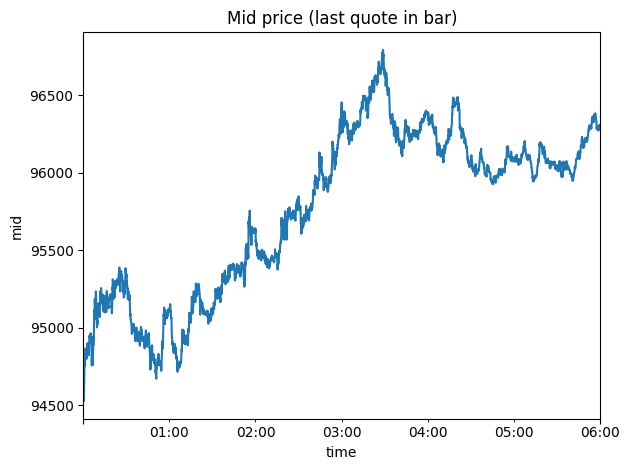

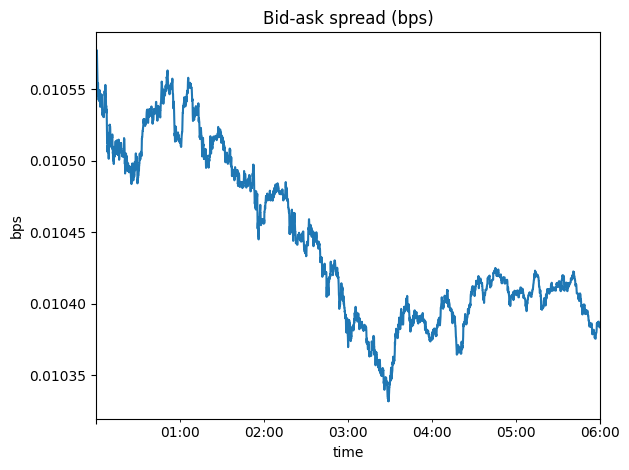

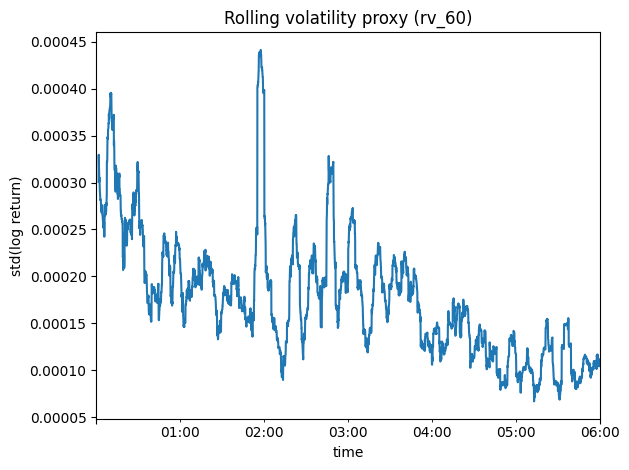

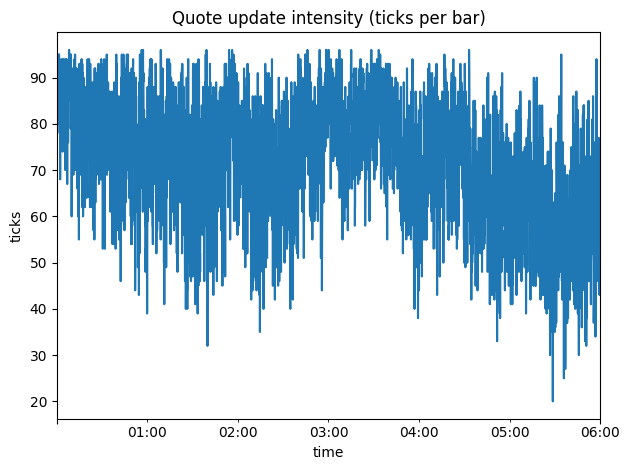

In [30]:
start = bars_hmm.index.min()
end = start + pd.Timedelta("6h")
window = bars_hmm.loc[start:end].copy()

plot_series(window["mid"], "Mid price (last quote in bar)", "mid")
plot_series(window["spread_bps"], "Bid-ask spread (bps)", "bps")
plot_series(window["rv_60"], "Rolling volatility proxy (rv_60)", "std(log return)")
plot_series(window["tick_count"], "Quote update intensity (ticks per bar)", "ticks")

# 2. Markov chains: persistence and geometric durations

## 2.1 The Markov property

A first‑order Markov chain ${s_t}$ satisfies:
$$
\mathbb{P}(s_t \mid s_{t-1}, s_{t-2}, \ldots) = \mathbb{P}(s_t \mid s_{t-1}).
$$
This is a modeling statement that the present regime summarizes the relevant past for predicting the next regime.

## 2.2 Transition matrix and persistence

For $K$ states, the chain is parameterized by a row‑stochastic transition matrix $A\in[0,1]^{K\times K}$:
$$
A_{ij} = \mathbb{P}(s_t=j\mid s_{t-1}=i),\qquad \sum_{j=0}^{K-1} A_{ij}=1.
$$

A key implication is the **geometric duration**. Conditional on being in state $i$, the probability that the state persists for exactly $d$ steps is
$$
\mathbb{P}(D_i=d) = (A_{ii})^{d-1}(1-A_{ii}),\qquad d=1,2,\dots
$$
and hence
$$
\mathbb{E}[D_i]=\frac{1}{1-A_{ii}}.
$$
This “memoryless” structure is often an approximation in finance; nonetheless it is the canonical baseline and provides immediate interpretability.

## 2.3 A proxy regime: thresholding volatility

Before inferring hidden regimes, we construct an observed proxy regime by thresholding a volatility proxy $rv_{60}$.

This serves two purposes:

1. It shows how regime persistence can be quantified even from a crude definition.
2. It provides intuition for what the HMM will do: replace a hard threshold with probabilistic inference and state persistence.

We define a two‑state proxy:
$$
s_t =
\begin{cases}
1 & \text{if } rv_{60,t} > \text{Quantile}_q(rv_{60})\\
0 & \text{otherwise.}
\end{cases}
$$
Given an observed state sequence, the maximum‑likelihood estimator of $A$ is the normalized transition count matrix.

Proxy regime threshold (q=0.7): 0.000229931
rv_60
0    0.7
1    0.3
Name: fraction, dtype: float64


,to 0,to 1
from 0,0.99457,0.00543
from 1,0.01267,0.98733


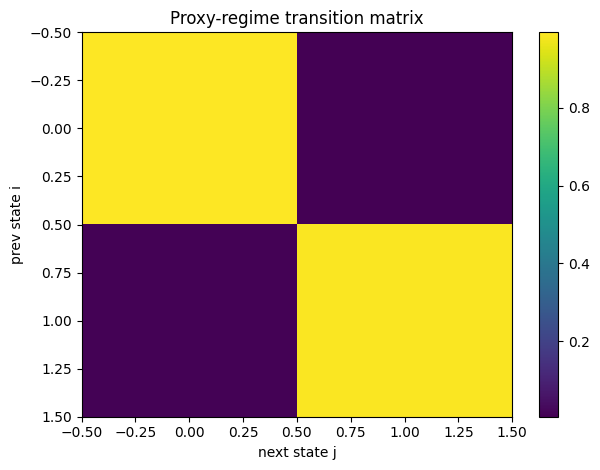

Theoretical Markovian duration (bars): [184.16751269  78.92639594]
State 0: 394 runs | mean=184.17 | median=16.0
State 1: 395 runs | mean=78.73 | median=17.0


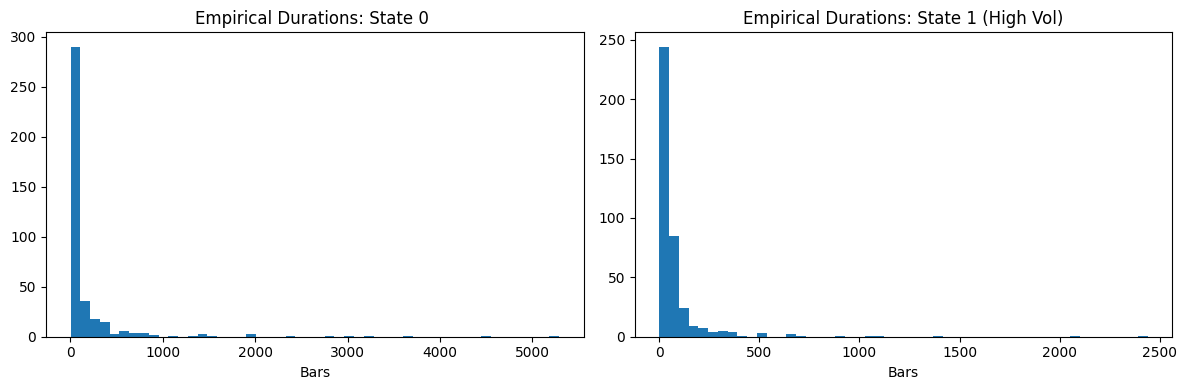

P(s_t=1 | s_103657=0): 0.005
P(s_t=1 | s_103657=1): 0.987


,s_{t-2},s_{t-1},"P(s_t=1 | s_{t-2}, s_{t-1})",count
0,0,0,0.004545,72168
1,0,1,0.875635,394
2,1,0,0.167513,394
3,1,1,0.988763,30702


In [31]:
# --- Proxy Regime Labeling ---
# Create a binary volatility regime using a quantile-based threshold 
vol = bars_hmm["rv_60"].copy().dropna()
q = 0.70
thr = vol.quantile(q)
s_proxy = (vol > thr).astype(int)

print(f"Proxy regime threshold (q={q}): {thr:.6g}")
print(s_proxy.value_counts(normalize=True).rename("fraction"))

# --- Transition Matrix Estimation ---
# Compute Maximum Likelihood Estimate (MLE) for the transition matrix A
s = s_proxy.values
K = 2
counts = np.zeros((K, K), dtype=np.float64)
for t in range(len(s) - 1):
    counts[s[t], s[t+1]] += 1

A_proxy = counts / counts.sum(axis=1, keepdims=True)
display(pd.DataFrame(A_proxy, index=[f"from {i}" for i in range(K)], columns=[f"to {j}" for j in range(K)]))

plot_transition_matrix(A_proxy, "Proxy-regime transition matrix")

# --- Duration Analysis ---
# Markovian assumption implies geometric distribution for state residence times
# Expected duration \( E[d] = \frac{1}{1 - P(i|i)} \)
expected_duration = 1.0 / (1.0 - np.diag(A_proxy))
print("Theoretical Markovian duration (bars):", expected_duration)

# Empirical run-length encoding (RLE)
durations_by_state = {0: [], 1: []}
current_state = s[0]
run_len = 1
for x in s[1:]:
    if x == current_state:
        run_len += 1
    else:
        durations_by_state[current_state].append(run_len)
        current_state = x
        run_len = 1
durations_by_state[current_state].append(run_len)

for i in range(K):
    d = np.array(durations_by_state[i], dtype=float)
    print(f"State {i}: {len(d)} runs | mean={d.mean():.2f} | median={np.median(d):.1f}")

# Visualizing run-length distributions for persistence diagnostics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.hist(durations_by_state[i], bins=50)
    ax.set_title(f"Empirical Durations: State {i} {'(High Vol)' if i==1 else ''}")
    ax.set_xlabel("Bars")
plt.tight_layout()
plt.show()

# --- Markov Order Diagnostic ---
# Checking for memory beyond first-order transitions. 
# Significant divergence in P(s_t | s_{t-1}, s_{t-2}) suggests 
# higher-order dependence or regime-switching mismatch.
s1 = s[2:]        
s_prev = s[1:-1]  
s_prev2 = s[:-2]  

def p_next_one(mask):
    return s1[mask].mean() if mask.sum() > 0 else np.nan

rows = []
for a in [0, 1]:
    for b in [0, 1]:
        mask = (s_prev2 == a) & (s_prev == b)
        rows.append({
            "s_{t-2}": a, 
            "s_{t-1}": b, 
            "P(s_t=1 | s_{t-2}, s_{t-1})": p_next_one(mask), 
            "count": int(mask.sum())
        })

print(f"P(s_t=1 | s_{t-1}=0): {p_next_one(s_prev == 0):.3f}")
print(f"P(s_t=1 | s_{t-1}=1): {p_next_one(s_prev == 1):.3f}")
display(pd.DataFrame(rows))

# 3. Hidden Markov Models (HMMs)

## 3.1 Definition and factorization

An HMM introduces:

- a latent Markov chain $s_t\in\{0,\dots,K-1\}$,
- an observation model $p(x_t\mid s_t)$,
- and conditional independence of observations given states.

Parameters:

- Initial distribution: $\pi_i=\mathbb{P}(s_1=i)$
- Transition matrix: $A_{ij}=\mathbb{P}(s_t=j\mid s_{t-1}=i)$
- Emission density: $b_j(x)=p(x\mid s=j)$

The joint distribution factorizes as:
$$
p(s_{1:T},x_{1:T})
= \pi_{s_1}\prod_{t=2}^T A_{s_{t-1},s_t}\prod_{t=1}^T b_{s_t}(x_t).
$$
The marginal likelihood is obtained by summing over states:
$$
p(x_{1:T})=\sum_{s_{1:T}} p(s_{1:T},x_{1:T}),
$$
which is intractable by brute force for realistic $T$. Dynamic programming (forward–backward, Viterbi) is therefore foundational.

## 3.2 Gaussian emissions for microstructure features

A common and pragmatic emission model is Gaussian:
$$
x_t\mid(s_t=i)\sim \mathcal{N}(\mu_i,\Sigma_i).
$$
We use **diagonal covariance** $\Sigma_i=\mathrm{diag}(\sigma^2_{i1},\dots,\sigma^2_{iD})$ for numerical stability and speed.

In high‑frequency finance, Gaussian emissions should be interpreted as an approximation after careful feature engineering (log transforms, smoothing, robust scaling).

## 3.3 Feature vector used in this notebook

From each bar we form a feature vector:
$$
x_t=
\Big(
\underbrace{\log(rv_t+\varepsilon)}_{\text{persistent volatility}},
\underbrace{\log(1+\text{spread\_bps}_t)}_{\text{transaction cost proxy}},
\underbrace{\text{imbalance}_t}_{\text{order book pressure}},
\underbrace{\log(\text{depth}_t)}_{\text{liquidity proxy}},
\underbrace{\log(1+\text{tick\_count}_t)}_{\text{activity proxy}}
\Big).
$$

Two econometric choices deserve emphasis:

1. Persistence in the volatility proxy. We use a rolling volatility estimate $rv_t$ rather than one‑bar $|r_t|$, because regimes are conceptually persistent.
2. Mild temporal smoothing of microstructure features. Liquidity variables can have “needle” spikes; smoothing helps the HMM target persistent shifts rather than single‑bar anomalies.

## 3.4 Initialization: why it matters and what we do

HMM maximum‑likelihood estimation (Baum–Welch/EM) is non‑convex. Initialization is therefore a modeling choice, not a mere implementation detail.

A common approach is:

- Fit a Gaussian mixture model (GMM) to $x_t$ ignoring time.
- Use mixture components to initialize $(\mu_i,\Sigma_i)$.
- Use transitions between mixture labels to initialize $A$.

We also include a persistence‑aware fallback that constructs initial labels from a smoothed volatility proxy. This mitigates the common failure mode in microstructure data where a mixture component becomes an “outlier bucket” rather than a persistent regime.

In [32]:
def make_hmm_feature_frame(bars_in: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms raw microstructure data into a feature matrix for Gaussian HMMs.
    
    Targeting roughly symmetric distributions to satisfy Gaussian emission 
    assumptions. We apply log-transforms to compressed heavy tails and EWMA 
    filters to improve Signal-to-Noise Ratio (SNR) by dampening microstructure 
    'needle spikes'.
    """
    df = pd.DataFrame(index=bars_in.index)
    eps = 1e-12

    # --- Volatility ---
    # Combine 60-bar rolling std with an EWMA fallback to minimize initialization lag
    rv = bars_in["rv_60"].copy()
    rv_fallback = bars_in["abs_r"].ewm(span=20, adjust=False, min_periods=10).mean()
    df["log_rv"] = np.log(rv.fillna(rv_fallback) + eps)

    # --- Microstructure Features ---
    # Apply EWMA smoothing to suppress high-frequency noise and improve state persistence
    smooth_span = 12
    min_p = 5

    # Spread: log1p used as spread is denominated in bps
    spread = bars_in["spread_bps"].clip(lower=0.0)
    df["log_spread"] = np.log1p(spread).ewm(span=smooth_span, adjust=False, min_periods=min_p).mean()

    # Imbalance: Clip to \([-1, 1]\) before smoothing
    df["imbalance"] = bars_in["imbalance"].clip(-1.0, 1.0).fillna(0.0)
    df["imbalance"] = df["imbalance"].ewm(span=smooth_span, adjust=False, min_periods=min_p).mean()

    # Depth & Intensity: Log-transform to handle order book scaling
    depth = bars_in["depth"].clip(lower=1e-6)
    df["log_depth"] = np.log(depth).ewm(span=smooth_span, adjust=False, min_periods=min_p).mean()

    df["log_intensity"] = np.log1p(bars_in["tick_count"].fillna(0.0))
    df["log_intensity"] = df["log_intensity"].ewm(span=smooth_span, adjust=False, min_periods=min_p).mean()

    # Drop warm-up periods and any residual invalid values
    return df.replace([np.inf, -np.inf], np.nan).dropna()

feat = make_hmm_feature_frame(bars_hmm)
print(f"Feature frame shape: {feat.shape}")
display(feat.head())

Feature frame shape: (103670, 5)


,log_rv,log_spread,imbalance,log_depth,log_intensity
bar_time,,,,,
2025-11-15 00:00:55+00:00,-8.071640,0.010513,0.715843,1.965365,4.466394
2025-11-15 00:01:00+00:00,-8.082627,0.010511,0.671272,1.912654,4.478225
2025-11-15 00:01:05+00:00,-8.155400,0.010508,0.506382,1.843409,4.488235
2025-11-15 00:01:10+00:00,-8.254711,0.010506,0.566123,1.850103,4.499945
2025-11-15 00:01:15+00:00,-8.242581,0.010505,0.386384,1.850743,4.494709


## 3.5 Diagnostics before fitting: discreteness, zero inflation, and tail behavior

Even after log transforms, high‑frequency features can be:

- discrete or zero‑inflated (e.g., intensity),
- heavy‑tailed (e.g., spread/depth in stressed periods),
- dominated by a few extreme events (data issues or microstructure spikes).

These properties matter because Gaussian emissions are sensitive to tails. The diagnostic below reports basic quantiles and uniqueness counts to highlight features that may require additional care.

In [33]:
def feature_discreteness_report(df):
    """Summarize discreteness/zero inflation and tail behavior of each feature."""
    out = []
    for c in df.columns:
        s = df[c]
        out.append({
            "feature": c,
            "n": len(s),
            "pct_zero": float((s == 0).mean()) if np.issubdtype(s.dtype, np.number) else np.nan,
            "n_unique": int(s.nunique(dropna=True)),
            "q50": float(s.quantile(0.50)),
            "q90": float(s.quantile(0.90)),
            "q99": float(s.quantile(0.99)),
            "q999": float(s.quantile(0.999)),
        })
    return pd.DataFrame(out)

print("\n[Diagnostic] Feature discreteness report:")
display(feature_discreteness_report(feat))


[Diagnostic] Feature discreteness report:


,feature,n,pct_zero,n_unique,q50,q90,q99,q999
0,log_rv,103670,0.0,97537,-8.672070,-7.985023,-7.475323,-7.129601
1,log_spread,103670,0.0,103670,0.010717,0.011100,0.012126,0.030488
2,imbalance,103670,0.0,103670,0.008582,0.287518,0.540868,0.709352
3,log_depth,103670,0.0,103670,2.152705,2.457473,2.698346,3.262964
4,log_intensity,103670,0.0,103670,4.306163,4.523343,4.570796,4.576428


## 3.6 Train/test split and robust standardization

Two practical considerations are crucial in financial time series:

1. Time‑ordered splits. Random splits leak information because adjacent observations are dependent.
2. Robust scaling. Standardization by mean and standard deviation can be distorted by heavy tails.

We therefore:

- Split the sequence chronologically into 70% train / 30% test.
- Compute scaling parameters on the training sample only.
- Use median/MAD scaling with fallbacks for near‑constant features.
- Clip standardized values to reduce the influence of extreme tails without discarding data.

In [34]:
K_HMM = 2

# Chronological split to prevent lookahead bias in model validation
split = int(0.7 * len(feat))
feat_train = feat.iloc[:split].copy()
feat_test = feat.iloc[split:].copy()

def robust_center_scale(train_df: pd.DataFrame, eps: float = 1e-12):
    """
    Computes robust scaling parameters using a multi-stage fallback for 
    low-variance features. Priority: MAD -> IQR -> StdDev.
    
    The constant 1.4826 is used to scale MAD to a consistent estimator of 
    the standard deviation for Gaussian distributions.
    """
    med = train_df.median(axis=0)

    # Median Absolute Deviation (primary for heavy-tailed financial data)
    mad = (train_df - med).abs().median(axis=0)
    sd_mad = 1.4826 * mad

    # Inter-quartile range fallback
    iqr = train_df.quantile(0.75) - train_df.quantile(0.25)
    sd_iqr = iqr / 1.349

    sd_std = train_df.std(axis=0, ddof=0)

    # Resolve numerical singularities for near-constant features
    sd = sd_mad.copy()
    sd = sd.mask(sd < eps, sd_iqr)
    sd = sd.mask(sd < eps, sd_std)
    sd = sd.replace([np.inf, -np.inf], np.nan).fillna(1.0)
    sd = sd.mask(sd < eps, 1.0)
    
    return med, sd

# Z-score clipping threshold to mitigate influence of extreme tails
Z_CLIP = 6.0 

def standardize_and_clip(feat_df: pd.DataFrame, mu: pd.Series, sd: pd.Series, clip: float | None) -> np.ndarray:
    """Applies pre-computed training stats to features to maintain consistent scaling."""
    Z = (feat_df - mu) / sd
    Z = Z.replace([np.inf, -np.inf], np.nan)
    
    if Z.isna().any().any():
        bad = Z.columns[Z.isna().any()].tolist()
        raise ValueError(f"Scaling failure - NaNs found in: {bad}")
        
    X = Z.to_numpy(dtype=np.float64)
    return np.clip(X, -clip, clip) if clip is not None else X

# Use training-set stats for all normalization to ensure valid out-of-sample testing
if USE_ROBUST_SCALING:
    mu_train, sd_train = robust_center_scale(feat_train)
else:
    mu_train = feat_train.mean(axis=0)
    sd_train = feat_train.std(axis=0).replace(0.0, 1.0)

X_train = standardize_and_clip(feat_train, mu_train, sd_train, clip=Z_CLIP)
X_test = standardize_and_clip(feat_test, mu_train, sd_train, clip=Z_CLIP)

# Validation of scaling hierarchy and convergence diagnostics
if USE_ROBUST_SCALING:
    scale_debug = pd.DataFrame({
        "median": feat_train.median(axis=0),
        "sd_mad": 1.4826 * (feat_train - feat_train.median(axis=0)).abs().median(axis=0),
        "sd_iqr": (feat_train.quantile(0.75) - feat_train.quantile(0.25)) / 1.349,
        "sd_std": feat_train.std(axis=0, ddof=0),
        "sd_final": sd_train,
    })
    print("\n[Scaling Diagnostic] Hierarchy resolution:")
    display(scale_debug)


[Scaling Diagnostic] Hierarchy resolution:


,median,sd_mad,sd_iqr,sd_std,sd_final
log_rv,-8.725584,0.514591,0.516554,0.502541,0.514591
log_spread,0.010478,0.000177,0.000270,0.001544,0.000177
imbalance,0.010947,0.224878,0.224834,0.229148,0.224878
log_depth,2.072182,0.226023,0.226324,0.253693,0.226023
log_intensity,4.273312,0.218065,0.219266,0.208235,0.218065


## 3.7 A non‑temporal baseline: Gaussian mixture model (GMM)

A GMM ignores time and clusters points in feature space:
$$
p(x)=\sum_{k=0}^{K-1} w_k\,\mathcal{N}(x\mid \mu_k,\Sigma_k).
$$

In regime modeling, a GMM serves two pedagogical and practical roles:

1. It provides a baseline segmentation that reflects feature separation without persistence.
2. It provides a reasonable initialization for the HMM’s emission parameters.

We fit the GMM in the standardized feature space and inspect cluster means in original units for interpretability.

Component Weights: [0.42845067 0.57154933]


,log_rv,log_spread,imbalance,log_depth,log_intensity
gmm_state,,,,,
0,-9.098204,0.010391,0.023916,2.093363,4.087028
1,-8.388761,0.010861,0.004593,2.038850,4.372354


,0,1
fraction,0.435902,0.564098


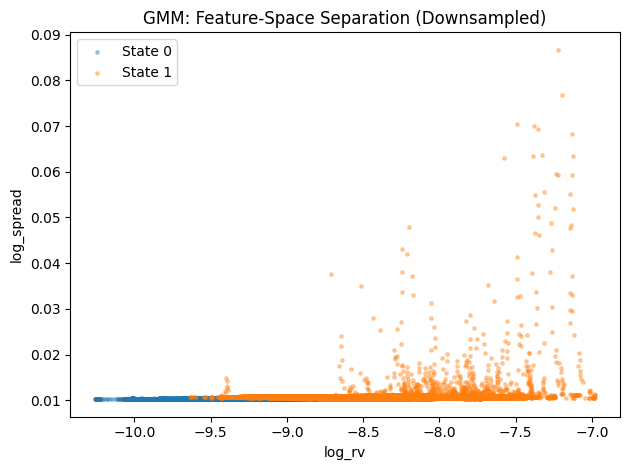

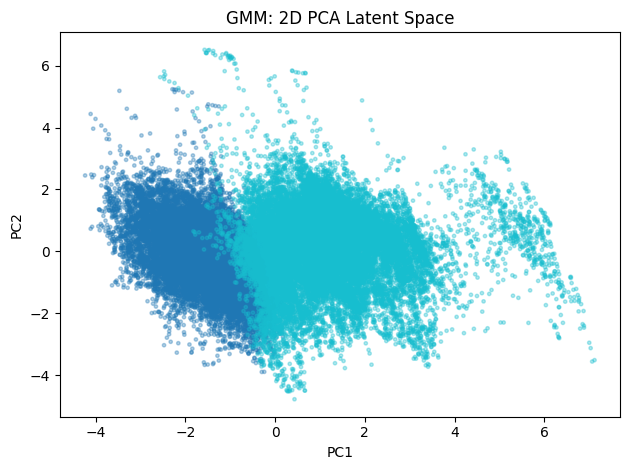

In [35]:
from sklearn.decomposition import PCA

# --- GMM Baseline (iid clustering) ---
# Diagonal covariance provides a regularized baseline to identify dominant 
# feature modes without modeling temporal transition probabilities.
gmm = GaussianMixture(n_components=K_HMM, covariance_type="diag", random_state=SEED)
gmm.fit(X_train)

labels_train = gmm.predict(X_train)
print(f"Component Weights: {gmm.weights_}")

# Project labels back to raw feature units to inspect regime characteristics
cluster_stats = feat_train.assign(gmm_state=labels_train).groupby("gmm_state").mean(numeric_only=True)
display(cluster_stats)

# Diagnostic for class imbalance (common in high-volatility microstructure regimes)
label_dist = pd.Series(labels_train).value_counts(normalize=True).sort_index()
display(label_dist.to_frame(name="fraction").T)

# --- Downsampling for Scatter Visualization ---
# Uniformly sample up to 25k points per state to manage overplotting and Matplotlib overhead
max_pts = 25_000
idx_all = np.arange(len(feat_train))
plot_idx_list = []

for k in range(K_HMM):
    idx_k = idx_all[labels_train == k]
    if len(idx_k) > max_pts:
        idx_k = rng.choice(idx_k, size=max_pts, replace=False)
    plot_idx_list.append(idx_k)

plot_idx = np.concatenate(plot_idx_list)

# Primary feature separation: Log Volatility vs. Log Spread
plt.figure()
for k in range(K_HMM):
    mask = labels_train[plot_idx] == k
    plt.scatter(
        feat_train["log_rv"].values[plot_idx][mask],
        feat_train["log_spread"].values[plot_idx][mask],
        s=6, alpha=0.35, label=f"State {k}"
    )
plt.title("GMM: Feature-Space Separation (Downsampled)")
plt.xlabel("log_rv")
plt.ylabel("log_spread")
plt.legend()
plt.tight_layout()
plt.show()

# --- PCA Projection ---
# Project cluster separation onto the top two Principal Components
Z_pca = PCA(n_components=2, random_state=SEED).fit_transform(X_train)

plt.figure()
plt.scatter(
    Z_pca[plot_idx, 0], 
    Z_pca[plot_idx, 1], 
    c=labels_train[plot_idx], 
    s=6, alpha=0.35, cmap="tab10"
)
plt.title("GMM: 2D PCA Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## 3.8 Initializing the HMM: emissions and transitions

The HMM adds state persistence through $A$, so we require an initialization for:

- $\pi$ (initial state probabilities),
- $A$ (transition matrix),
- $\mu_k,\Sigma_k$ (Gaussian emission parameters).

A standard construction is:

- set $\mu_k,\Sigma_k,\pi_k$ from the GMM fit,
- estimate an empirical transition matrix by counting transitions between GMM labels through time.

In microstructure data, mixtures can sometimes allocate a tiny “tail” component. Because an HMM’s emissions overlap and $A$ encourages persistence, it is often preferable for regimes to be **persistent modes**, not “outlier buckets.” We therefore include a persistence‑aware alternative that constructs initial labels from a smoothed volatility proxy and then estimates a sticky initial $A$.

Initial Transition Matrix A0:


,to 0,to 1
from 0,0.991054,0.008946
from 1,0.006913,0.993087


Implied residence times (bars): [111.7844523  144.65371025]


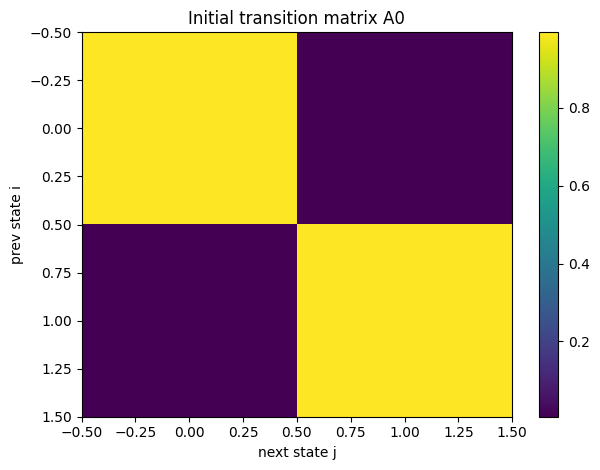

In [36]:
def make_sticky_A(K: int, p_stay: float):
    """
    Constructs a transition matrix with a high diagonal prior. 
    Controls the theoretical residence time for the cold-start.
    """
    A = np.full((K, K), (1.0 - p_stay) / (K - 1))
    np.fill_diagonal(A, p_stay)
    return A

def init_from_proxy_labels(X: np.ndarray, labels: np.ndarray, K: int, min_var: float = 1e-2):
    """
    Derives initial HMM parameters from a provided label sequence.
    
    Includes Laplacian (add-one) smoothing for transitions and shrinkage 
    toward a persistent prior to prevent state collapse during early EM steps.
    """
    mu0 = np.zeros((K, X.shape[1]))
    var0 = np.zeros((K, X.shape[1]))
    pi0 = np.zeros(K)

    for k in range(K):
        mask = labels == k
        if mask.sum() < 10:
            raise ValueError(f"State {k} sample size too small for covariance init.")
        Xk = X[mask]
        pi0[k] = mask.mean()
        mu0[k] = Xk.mean(axis=0)
        # Floor variance to prevent singularities in emission density calculations
        var0[k] = np.maximum(Xk.var(axis=0, ddof=0), min_var)

    # Calculate empirical transitions with Laplacian smoothing
    counts = np.zeros((K, K), dtype=float)
    for t in range(len(labels) - 1):
        counts[labels[t], labels[t+1]] += 1
    A_emp = (counts + 1.0) / (counts.sum(axis=1, keepdims=True) + K)

    # Regularize empirical transitions toward a sticky (persistent) prior
    A_sticky = make_sticky_A(K, p_stay=0.97)
    shrink = 0.5
    A0 = (1 - shrink) * A_emp + shrink * A_sticky

    return pi0 / pi0.sum(), A0, mu0, var0

# --- Parameter Initialization ---

# Check for GMM component collapse. If one component traps a 
# distribution tail, weights will be highly imbalanced.
min_w = float(gmm.weights_.min())
GMM_IMBALANCE_THRESHOLD = 0.10

if min_w < GMM_IMBALANCE_THRESHOLD:
    # FALLBACK: GMM failed to find meaningful regimes. Use a volatility-based 
    # proxy label to initialize a persistence-aware HMM.
    proxy = feat_train["log_rv"].ewm(span=20, adjust=False, min_periods=20).mean()
    proxy = proxy.dropna()

    # Align features with proxy (handles EWMA warm-up period)
    valid_idx = proxy.index.intersection(feat_train.index)
    X_train_df = pd.DataFrame(X_train, index=feat_train.index)
    X_train_aligned = X_train_df.loc[valid_idx].to_numpy()

    # High-vol regime = top 30% of rolling vol
    thr = proxy.quantile(0.70)
    labels_init = (proxy.loc[valid_idx] > thr).astype(int).to_numpy()

    pi0, A0, mu0, var0 = init_from_proxy_labels(
        X_train_aligned, labels_init, K_HMM, min_var=1e-2
    )
else:
    # GMM is well-behaved; initialize from GMM emission params 
    # and empirical transitions (with smoothing).
    pi0, mu0, var0 = gmm.weights_, gmm.means_, gmm.covariances_
    
    counts = np.zeros((K_HMM, K_HMM), dtype=float)
    for t in range(len(labels_train) - 1):
        counts[labels_train[t], labels_train[t+1]] += 1
    A0 = (counts + 1.0) / (counts.sum(axis=1, keepdims=True) + K_HMM)

# Theoretical residence time: \( E[d] = \frac{1}{1 - A_{ii}} \)
print("Initial Transition Matrix A0:")
display(pd.DataFrame(A0, index=[f"from {i}" for i in range(K_HMM)], 
                     columns=[f"to {j}" for j in range(K_HMM)]))
print("Implied residence times (bars):", 1.0 / (1.0 - np.diag(A0)))
plot_transition_matrix(A0, "Initial transition matrix A0")

# 4. Emission likelihoods for diagonal Gaussian HMMs

All HMM inference algorithms require emission likelihoods
$$
b_j(x_t)=p(x_t\mid s_t=j),
\qquad\text{or equivalently}\qquad
\log b_j(x_t).
$$

For a diagonal Gaussian emission $x_t\sim\mathcal{N}(\mu_j,\mathrm{diag}(\sigma^2_{j1},\dots,\sigma^2_{jD}))$,
$$
\log b_j(x_t)
=
-\frac{D}{2}\log(2\pi)
-\frac{1}{2}\sum_{d=1}^D \log \sigma^2_{jd}
-\frac{1}{2}\sum_{d=1}^D \frac{(x_{td}-\mu_{jd})^2}{\sigma^2_{jd}}.
$$

We work in **log space** because likelihood products over long sequences underflow in floating‑point arithmetic.

In [37]:
def gaussian_diag_logpdf(X: np.ndarray, mu: np.ndarray, var: np.ndarray) -> np.ndarray:
    '''
    X:   (T, D)
    mu:  (K, D)
    var: (K, D)  (diagonal variances; must be > 0)

    returns logB: (T, K) where logB[t,k] = log N(X[t] | mu[k], diag(var[k]))
    '''
    T, D = X.shape
    K = mu.shape[0]
    logB = np.empty((T, K), dtype=np.float64)

    const = -0.5 * D * np.log(2.0 * np.pi)
    for k in range(K):
        v = np.maximum(var[k], 1e-12)
        log_det = -0.5 * np.sum(np.log(v))
        quad = -0.5 * np.sum(((X - mu[k]) ** 2) / v, axis=1)
        logB[:, k] = const + log_det + quad

    return logB


# Compute initial emission log-likelihoods under the initialized parameters
logB0 = gaussian_diag_logpdf(X_train, mu0, var0)
print("logB0 shape:", logB0.shape)
print("First row (t=0) log-likelihood per state:", logB0[0])

logB0 shape: (72569, 2)
First row (t=0) log-likelihood per state: [-18.54984597 -11.81185404]


# 5. Forward–Backward: filtering and smoothing

## 5.1 Dynamic programming necessity

The HMM likelihood marginalizes over all state sequences $s_{1:T}$, which grows as $K^T$.
The forward–backward algorithm exploits the Markov and conditional independence structure to compute posterior quantities in $O(TK^2)$.

## 5.2 Forward and backward recursions

Define the **forward message**
$$
\alpha_t(j)=p(x_{1:t}, s_t=j)
$$
with recursion
$$
\alpha_t(j)=b_j(x_t)\sum_{i=0}^{K-1}\alpha_{t-1}(i)A_{ij},
\qquad
\alpha_1(j)=\pi_j b_j(x_1).
$$

Define the **backward message**
$$
\beta_t(i)=p(x_{t+1:T}\mid s_t=i)
$$
with recursion
$$
\beta_t(i)=\sum_{j=0}^{K-1}A_{ij}b_j(x_{t+1})\beta_{t+1}(j),
\qquad
\beta_T(i)=1.
$$

From these we obtain:

- **Filtered probabilities** (online, causal):
$$
  p(s_t=j\mid x_{1:t})=\frac{\alpha_t(j)}{\sum_\ell \alpha_t(\ell)}.
$$
- **Smoothed probabilities** (offline):
$$
  p(s_t=j\mid x_{1:T})=\frac{\alpha_t(j)\beta_t(j)}{\sum_\ell \alpha_t(\ell)\beta_t(\ell)}.
$$
- **Expected transition counts**:
$$
  \xi_t(i,j)=p(s_t=i,s_{t+1}=j\mid x_{1:T})
  \propto
  \alpha_t(i)A_{ij}b_j(x_{t+1})\beta_{t+1}(j).
$$

We implement these computations in log space using `logsumexp`.

## 5.3 A correctness check: brute force on a tiny sequence

On $T=10$ and $K=2$, brute force sums over only $2^{10}=1024$ sequences. We verify that brute force and forward recursion agree numerically.

Initial log-likelihood: -429411.5466


/var/folders/r3/hk9qq_td10l_xnrsz1qm58jr0000gn/T/ipykernel_34481/3426347940.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Initial log-likelihood: {float(fb0['loglik']):.4f}")


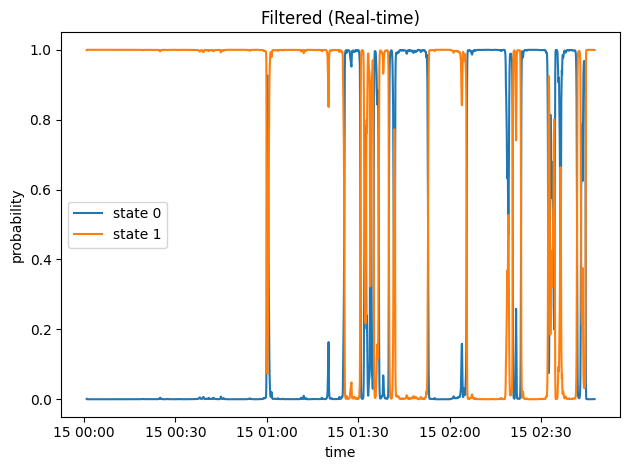

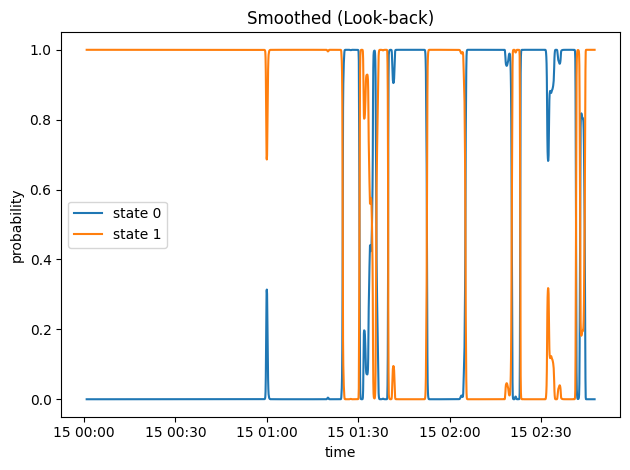

Brute-force LL: -88.066720 | Forward LL: -88.066720
Absolute Err: 2.84e-14


/var/folders/r3/hk9qq_td10l_xnrsz1qm58jr0000gn/T/ipykernel_34481/3426347940.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fb_ll = float(fb_res["loglik"])


In [38]:
import itertools

def forward_backward_log(
    log_pi: np.ndarray, 
    log_A: np.ndarray, 
    logB: np.ndarray
) -> Dict[str, np.ndarray]:
    """
    Standard Forward-Backward recursion in the log-domain.
    
    Uses the logsumexp trick to prevent numerical underflow in the recursive 
    summation of paths. Returns smoothed state probabilities (gamma) and 
    expected transition counts (xi_sum) for the EM M-step.
    """
    T, K = logB.shape

    # --- Forward Pass (Alpha) ---
    # log_alpha[t, k] = log P(x_1:t, s_t=k)
    log_alpha = np.empty((T, K), dtype=np.float64)
    log_alpha[0] = log_pi + logB[0]
    for t in range(1, T):
        # Broadcast previous alpha across transitions and marginalize
        log_alpha[t] = logB[t] + logsumexp(log_alpha[t-1][:, None] + log_A, axis=0)

    loglik = logsumexp(log_alpha[-1])

    # Filtered probabilities: P(s_t | x_1:t)
    log_filt = log_alpha - logsumexp(log_alpha, axis=1, keepdims=True)
    filt = np.exp(log_filt)

    # --- Backward Pass (Beta) ---
    # log_beta[t, k] = log P(x_{t+1}:T | s_t=k)
    log_beta = np.empty((T, K), dtype=np.float64)
    log_beta[-1] = 0.0  # Terminal condition
    for t in range(T - 2, -1, -1):
        log_beta[t] = logsumexp(log_A + logB[t + 1][None, :] + log_beta[t + 1][None, :], axis=1)

    # --- Posterior Smoothing (Gamma & Xi) ---
    # P(s_t | x_1:T)
    log_gamma = log_alpha + log_beta - loglik
    gamma = np.exp(log_gamma)

    # Expected transition counts \(\sum_t P(s_t, s_{t+1} | x_{1:T})\)
    xi_sum = np.zeros((K, K), dtype=np.float64)
    for t in range(T - 1):
        log_xi_t = (
            log_alpha[t][:, None] + 
            log_A + 
            logB[t + 1][None, :] + 
            log_beta[t + 1][None, :]
        )
        log_xi_t -= logsumexp(log_xi_t)
        xi_sum += np.exp(log_xi_t)

    return {
        "log_alpha": log_alpha,
        "log_beta": log_beta,
        "gamma": gamma,
        "xi_sum": xi_sum,
        "loglik": np.array([loglik]),
        "filt": filt,
    }

# Execution with cold-start parameters
log_pi0 = np.log(np.maximum(pi0, 1e-12))
log_A0 = np.log(np.maximum(A0, 1e-12))
logB0 = gaussian_diag_logpdf(X_train, mu0, var0)

fb0 = forward_backward_log(log_pi0, log_A0, logB0)
print(f"Initial log-likelihood: {float(fb0['loglik']):.4f}")

# Visualization of filtered vs smoothed state estimations
t0, t1 = 0, min(2000, len(feat_train))
time_idx = feat_train.index[t0:t1]

plot_probabilities(time_idx, fb0["filt"][t0:t1], "Filtered (Real-time)")
plot_probabilities(time_idx, fb0["gamma"][t0:t1], "Smoothed (Look-back)")

# --- Verification Unit Test ---
# Validates recursion against exhaustive state-path summation for T=10
def brute_force_loglik(X_s, pi, A, mu, var):
    K, T = len(pi), X_s.shape[0]
    logB_s = gaussian_diag_logpdf(X_s, mu, var)
    total = 0.0
    for seq in itertools.product(range(K), repeat=T):
        p = pi[seq[0]] * np.exp(logB_s[0, seq[0]])
        for t in range(1, T):
            p *= A[seq[t-1], seq[t]] * np.exp(logB_s[t, seq[t]])
        total += p
    return float(np.log(total))

T_test = 10
bf_ll = brute_force_loglik(X_train[:T_test], pi0, A0, mu0, var0)
fb_res = forward_backward_log(log_pi0, log_A0, logB0[:T_test])
fb_ll = float(fb_res["loglik"])

print(f"Brute-force LL: {bf_ll:.6f} | Forward LL: {fb_ll:.6f}")
print(f"Absolute Err: {abs(bf_ll - fb_ll):.2e}")

# 6. Baum–Welch (EM) for Gaussian‑emission HMMs

## 6.1 EM viewpoint

Let $\theta=(\pi,A,\{\mu_i,\Sigma_i\}_{i=0}^{K-1})$. We seek
$$
\max_\theta \log p(x_{1:T}\mid \theta).
$$

EM alternates:

- **E‑step:** compute posterior expectations under $\theta^{(old)}$, notably  
  $\gamma_t(i)=p(s_t=i\mid x_{1:T},\theta^{(old)})$ and $\xi_t(i,j)=p(s_t=i,s_{t+1}=j\mid x_{1:T},\theta^{(old)})$.

- **M‑step:** maximize the expected complete‑data log‑likelihood
$$
  Q(\theta,\theta^{(old)})=\mathbb{E}\big[\log p(s_{1:T},x_{1:T}\mid \theta)\,\big|\,x_{1:T},\theta^{(old)}\big].
$$

## 6.2 Closed‑form updates

Without priors, the updates are:

- Initial distribution:
$$
  \pi_i \leftarrow \gamma_1(i).
$$
- Transition matrix:
$$
  A_{ij} \leftarrow \frac{\sum_{t=1}^{T-1}\xi_t(i,j)}{\sum_{t=1}^{T-1}\gamma_t(i)}.
$$
- Gaussian parameters (weighted moments):
$$
  \mu_i \leftarrow \frac{\sum_{t=1}^T \gamma_t(i)\,x_t}{\sum_{t=1}^T \gamma_t(i)},
  \qquad
  \Sigma_i \leftarrow \frac{\sum_{t=1}^T \gamma_t(i)(x_t-\mu_i)(x_t-\mu_i)^\top}{\sum_{t=1}^T \gamma_t(i)}.
$$
For diagonal covariance, we update each variance component separately.

Practically, we enforce a minimum variance floor to avoid numerically singular states.

/var/folders/r3/hk9qq_td10l_xnrsz1qm58jr0000gn/T/ipykernel_34481/1684691534.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loglik = float(fb["loglik"])


iter 01/25 | loglik=-429411.547
iter 05/25 | loglik=-428877.264
iter 10/25 | loglik=-428877.150
iter 15/25 | loglik=-428877.150
iter 20/25 | loglik=-428877.150
iter 25/25 | loglik=-428877.150


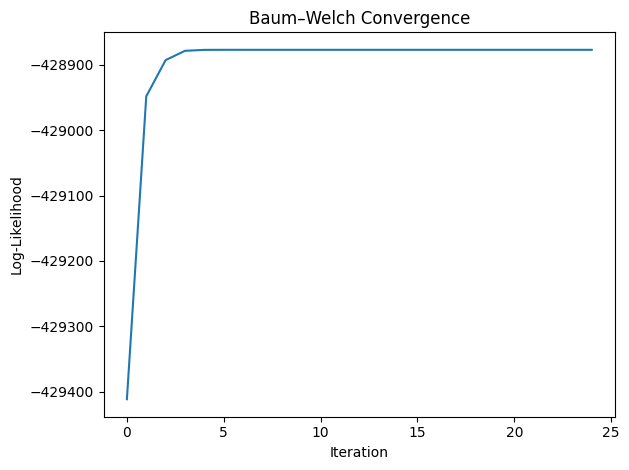

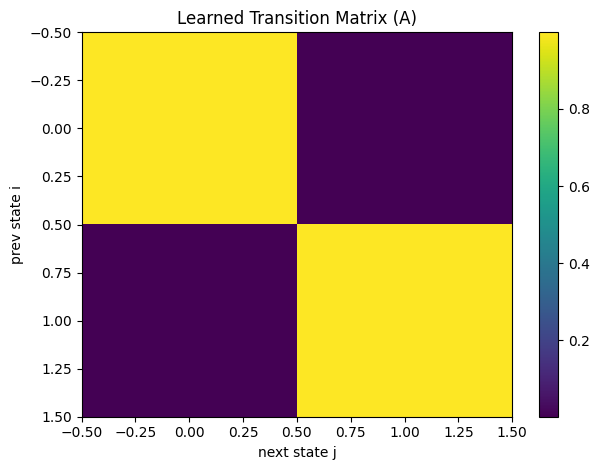

,log_rv,log_spread,imbalance,log_depth,log_intensity
0,-9.075388,0.010392,0.023472,2.087263,4.097697
1,-8.381241,0.010742,0.004239,2.041222,4.374125


Full-sample loglik: -681906.835


/var/folders/r3/hk9qq_td10l_xnrsz1qm58jr0000gn/T/ipykernel_34481/1684691534.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Full-sample loglik: {float(fb_all['loglik']):.3f}")


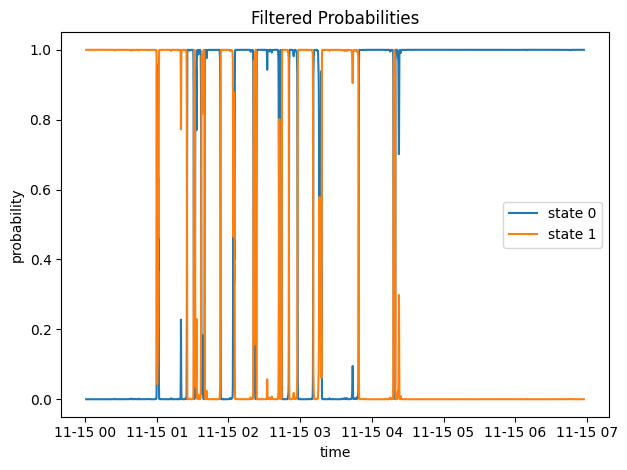

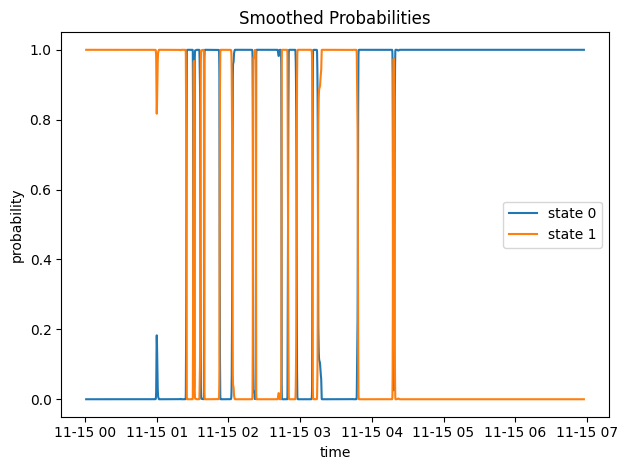

In [39]:
def baum_welch_gaussian_diag(
    X: np.ndarray,
    K: int,
    n_iter: int,
    pi_init: np.ndarray,
    A_init: np.ndarray,
    mu_init: np.ndarray,
    var_init: np.ndarray,
    min_var: float = 1e-6,
    verbose: bool = True,
) -> Dict[str, np.ndarray]:
    # Normalize priors and transitions to ensure valid distributions
    pi = np.maximum(pi_init, 1e-12).astype(float)
    pi = pi / pi.sum()

    A = np.maximum(A_init, 1e-12).astype(float)
    A = A / A.sum(axis=1, keepdims=True)

    mu = mu_init.astype(float).copy()
    var = np.maximum(var_init.astype(float).copy(), min_var)

    loglik_hist = []

    for it in range(n_iter):
        # E-step: Compute posteriors and sufficient statistics in log-space
        log_pi = np.log(np.maximum(pi, 1e-12))
        log_A = np.log(np.maximum(A, 1e-12))
        logB = gaussian_diag_logpdf(X, mu, var)

        fb = forward_backward_log(log_pi, log_A, logB)
        gamma = fb["gamma"]
        xi_sum = fb["xi_sum"]
        loglik = float(fb["loglik"])
        loglik_hist.append(loglik)

        # M-step: Update transitions and emission parameters
        pi = np.maximum(gamma[0], 1e-12)
        pi = pi / pi.sum()

        A = np.maximum(xi_sum, 1e-12)
        A = A / A.sum(axis=1, keepdims=True)

        # Update Gaussian parameters via weighted moments
        gamma_sum = gamma.sum(axis=0)
        mu = (gamma.T @ X) / gamma_sum[:, None]
        Ex2 = (gamma.T @ (X**2)) / gamma_sum[:, None]
        
        # Enforce variance floor to prevent collapse on singular points
        var = np.maximum(Ex2 - mu**2, min_var)

        if verbose:
            if it == 0 or (it + 1) % 5 == 0 or it == n_iter - 1:
                print(f"iter {it+1:02d}/{n_iter} | loglik={loglik:.3f}")

    return {
        "pi": pi,
        "A": A,
        "mu": mu,
        "var": var,
        "loglik_hist": np.array(loglik_hist),
    }


TRAIN_MAX = None
X_bw = X_train if TRAIN_MAX is None else X_train[:TRAIN_MAX]

params = baum_welch_gaussian_diag(
    X=X_bw,
    K=K_HMM,
    n_iter=25,
    pi_init=pi0,
    A_init=A0,
    mu_init=mu0,
    var_init=var0,
    min_var=1e-2,
    verbose=True,
)

plt.figure()
plt.plot(params["loglik_hist"])
plt.title("Baum–Welch Convergence")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.tight_layout()
plt.show()

plot_transition_matrix(params["A"], "Learned Transition Matrix (A)")

# Map standardized state means back to original feature space for analysis
mu_state_orig = mu_train.values[None, :] + sd_train.values[None, :] * params["mu"]
mu_state_orig = pd.DataFrame(mu_state_orig, columns=feat_train.columns)
display(mu_state_orig)

# Inference on full dataset using learned parameters
X_all = standardize_and_clip(feat, mu_train, sd_train, clip=Z_CLIP)
logB_all = gaussian_diag_logpdf(X_all, params["mu"], params["var"])

fb_all = forward_backward_log(
    np.log(np.maximum(params["pi"], 1e-12)),
    np.log(np.maximum(params["A"], 1e-12)),
    logB_all,
)

print(f"Full-sample loglik: {float(fb_all['loglik']):.3f}")

# Visualize regime probabilities for a localized window
t0, t1 = 0, min(5000, len(feat))
time_index_all = feat.index[t0:t1]
plot_probabilities(
    time_index_all, fb_all["filt"][t0:t1], "Filtered Probabilities"
)
plot_probabilities(
    time_index_all, fb_all["gamma"][t0:t1], "Smoothed Probabilities"
)

# 7. Viterbi decoding vs posterior regime probabilities

Once an HMM is fit, there are two conceptually different “labels” you can extract:

## 7.1 Posterior probabilities (soft classification)

- Filtered: $p(s_t\mid x_{1:t})$ — the causal object for live use.
- Smoothed: $p(s_t\mid x_{1:T})$ — the best historical segmentation (uses future information).

These are uncertainty‑aware; they quantify confidence in each regime.

## 7.2 Viterbi path (hard segmentation)

Viterbi produces the most probable single state sequence:
$$
\hat{s}_{1:T}=\arg\max_{s_{1:T}} p(s_{1:T}\mid x_{1:T}).
$$
It solves the dynamic program:
$$
\delta_t(j)=\log b_j(x_t)+\max_i\{\delta_{t-1}(i)+\log A_{ij}\}.
$$

Viterbi is useful for regime duration statistics and for downstream pipelines that require a single path, but it discards uncertainty.

Viterbi path length: 103670 | Unique states: [0 1]
Viterbi/Smoothed Agreement: 1.000


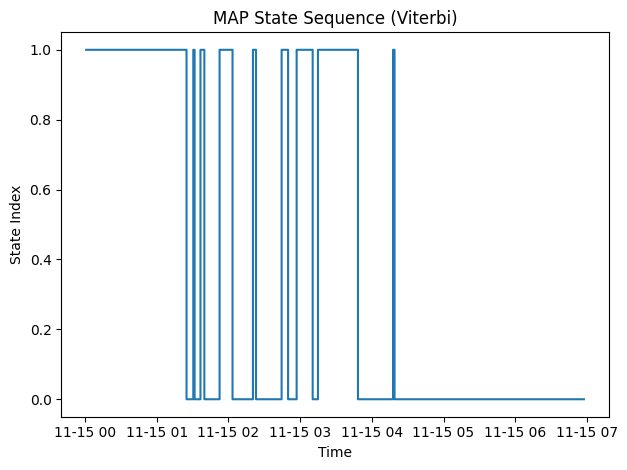

,log_rv,log_spread,imbalance,log_depth,log_intensity
state_viterbi,,,,,
0,-9.075602,0.010392,0.023467,2.087548,4.097597
1,-8.439699,0.010971,0.003677,2.165501,4.366028


State 0: n_runs=39 | Mean dur=848.59 | Median=352.0
State 1: n_runs=40 | Mean dur=1764.38 | Median=59.5

Regime Persistence Diagnostics

Transition Matrix A:
[[0.99877969 0.00122031]
 [0.00102434 0.99897566]]

Theoretical Expected Durations (bars): [819.46333521 976.23866202]
Viterbi Occupancy: {0: 0.3192341082280313, 1: 0.6807658917719688}
Mean Switch Rate: 0.0008
Observed Inter-switch Interval: 1329.1 bars


In [40]:
def viterbi_log(log_pi: np.ndarray, log_A: np.ndarray, logB: np.ndarray) -> np.ndarray:
    """
    Standard max-sum algorithm in log-space to prevent underflow.
    Returns the MAP (Maximum A Posteriori) state sequence.
    """
    T, K = logB.shape
    delta = np.empty((T, K), dtype=np.float64)
    psi = np.empty((T, K), dtype=np.int64)

    # Initialization
    delta[0] = log_pi + logB[0]
    psi[0] = -1

    # Recursion: vectorized over states K
    for t in range(1, T):
        # tmp[i, j] = log prob of being in state i at t-1 and transitioning to j
        tmp = delta[t - 1][:, None] + log_A
        psi[t] = np.argmax(tmp, axis=0)
        # delta[t, j] = max log prob of any path ending in state j at time t
        delta[t] = logB[t] + tmp[psi[t], np.arange(K)]

    # Backtracking
    path = np.empty(T, dtype=np.int64)
    path[-1] = int(np.argmax(delta[-1]))
    for t in range(T - 2, -1, -1):
        path[t] = psi[t + 1, path[t + 1]]

    return path


log_pi = np.log(np.maximum(params["pi"], 1e-12))
log_A = np.log(np.maximum(params["A"], 1e-12))

v_path = viterbi_log(log_pi, log_A, logB_all)
print(f"Viterbi path length: {len(v_path)} | Unique states: {np.unique(v_path)}")

# Verify Viterbi (jointly optimal) against marginal argmax (locally optimal)
gamma_argmax = np.argmax(fb_all["gamma"], axis=1)
agree = (v_path == gamma_argmax).mean()
print(f"Viterbi/Smoothed Agreement: {agree:.3f}")

t0, t1 = 0, min(5000, len(feat))
time_idx = feat.index[t0:t1]

plt.figure()
plt.plot(time_idx, v_path[t0:t1], drawstyle="steps-post")
plt.title("MAP State Sequence (Viterbi)")
plt.xlabel("Time")
plt.ylabel("State Index")
plt.tight_layout()
plt.show()

# Calculate regime-conditional feature statistics using Viterbi labels
feat_v = feat.copy()
feat_v["state_viterbi"] = v_path
display(feat_v.groupby("state_viterbi").mean(numeric_only=True))

# Empirical run-length encoding for regime duration analysis
durations = {k: [] for k in range(K_HMM)}
cur_state = v_path[0]
count = 1
for state in v_path[1:]:
    if state == cur_state:
        count += 1
    else:
        durations[cur_state].append(count)
        cur_state = state
        count = 1
durations[cur_state].append(count)

for k in range(K_HMM):
    d = np.array(durations[k], dtype=float)
    if len(d) > 0:
        print(f"State {k}: n_runs={len(d)} | Mean dur={d.mean():.2f} | Median={np.median(d):.1f}")

print("\n" + "=" * 70)
print("Regime Persistence Diagnostics")
print("=" * 70)
print("\nTransition Matrix A:")
print(params["A"])

# Theoretical expected duration for a geometric distribution is 1 / (1 - p_ii)
expected_durations = 1.0 / (1.0 - np.diag(params["A"]))
print("\nTheoretical Expected Durations (bars):", expected_durations)

# Distribution of state occupancy
occupancy = pd.Series(v_path).value_counts(normalize=True).sort_index().to_dict()
print("Viterbi Occupancy:", occupancy)

# Compute global chain switch rate
switch_rate = (v_path[1:] != v_path[:-1]).mean()
print(f"Mean Switch Rate: {switch_rate:.4f}")
if switch_rate > 0:
    print(f"Observed Inter-switch Interval: {1.0 / switch_rate:.1f} bars")

# 8. Regime switching vs change‑point detection

Regime‑switching and change‑point detection answer different questions.

## 8.1 Regime switching (HMM / Markov switching)

- The state space is small and **recurrent**: $0\to1\to0\to\cdots$.
- Switching can occur many times; regimes are interpreted as *modes* of behavior.
- The natural output is a **probability over regimes** through time.

## 8.2 Change‑point detection

- The objective is to detect **segment boundaries** where the data‑generating mechanism changes.
- In many formulations, once a change occurs, the “post‑change” regime persists for some time.
- The output is typically a sequence of alarm times or boundary probabilities.

In market data, a volatility shock may be a genuine structural break—or simply a temporary excursion to a stress regime that later reverts. The two toolkits are therefore complementary.

Below we overlay HMM regime switches (from the Viterbi path) on a coarser volatility proxy.

Number of minute-level regime switches: 78


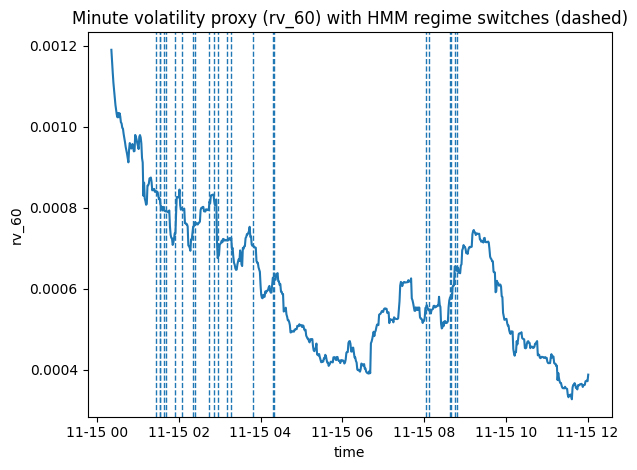

State counts in this window:


state
0    558
1    163
Name: count, dtype: int64

In [41]:
# Align HMM Viterbi regimes (bars_hmm) onto minute bars for comparison
state_hmm = pd.Series(v_path, index=feat.index, name="state")
state_min = state_hmm.resample(CPD_FREQ, label="right", closed="right") \
                     .agg(lambda x: x.value_counts().idxmax()) \
                     .astype(int)

vol_min = bars_cpd["rv_60"].copy()
vol_min = vol_min.loc[state_min.index]  # align

# Find regime switch times on minute grid
switch_times = state_min.index[state_min.diff().fillna(0).abs() > 0]

print(f"Number of minute-level regime switches: {len(switch_times)}")

# Plot volatility proxy with vertical lines at HMM switches (short window)
start = vol_min.index.min()
end = start + pd.Timedelta("12h")
vol_win = vol_min.loc[start:end]
switch_win = switch_times[(switch_times >= start) & (switch_times <= end)]

plt.figure()
plt.plot(vol_win.index, vol_win.values)
for t in switch_win:
    plt.axvline(t, linestyle="--", linewidth=1)
plt.title("Minute volatility proxy (rv_60) with HMM regime switches (dashed)")
plt.xlabel("time")
plt.ylabel("rv_60")
plt.tight_layout()
plt.show()


print("State counts in this window:")
display(state_min.loc[start:end].value_counts())

# 9. Bayesian regularization and online change‑point probabilities

Bayesian ideas enter this chapter in two practical ways:

## 9.1 Sticky transitions via Dirichlet priors

Transition matrices estimated by MLE can “chatter” when emissions overlap. A principled regularization is a Dirichlet prior on each row of $A$:
$$
A_{i,\cdot}\sim\mathrm{Dirichlet}(\alpha_{i0},\dots,\alpha_{i,K-1}).
$$
In MAP‑EM, the transition update becomes:
$$
A_{ij}\propto \sum_{t=1}^{T-1}\xi_t(i,j)+\alpha_{ij}-1.
$$
A “sticky” prior increases $\alpha_{ii}$ relative to off‑diagonal entries.

## 9.2 Bayesian Online Change‑Point Detection (BOCPD)

BOCPD maintains a posterior over the **run length** $r_t$, the number of steps since the most recent change point. With a hazard function $H$ and a predictive likelihood, BOCPD outputs:
$$
\mathbb{P}(r_t=0\mid y_{1:t}),
$$
interpretable as the probability that a change occurred at time $t$.

We apply BOCPD to a standardized minute‑level log‑volatility series with a Normal–Inverse‑Gamma prior (yielding Student‑t predictive likelihoods).

/var/folders/r3/hk9qq_td10l_xnrsz1qm58jr0000gn/T/ipykernel_34481/3441534138.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loglik = float(fb["loglik"])


iter 01/25 | loglik=-429411.547
iter 05/25 | loglik=-428877.363
iter 10/25 | loglik=-428877.273
iter 15/25 | loglik=-428877.273
iter 20/25 | loglik=-428877.273
iter 25/25 | loglik=-428877.273


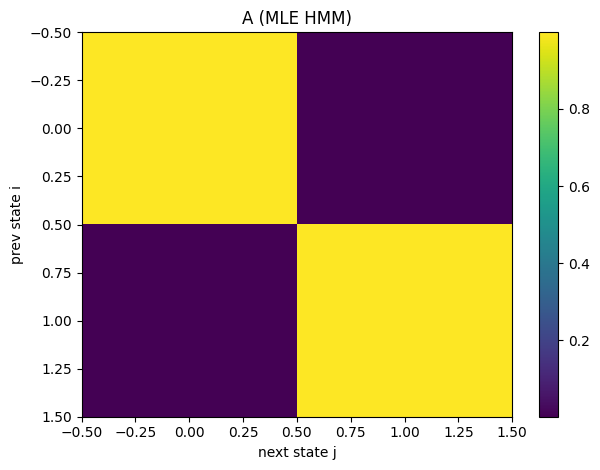

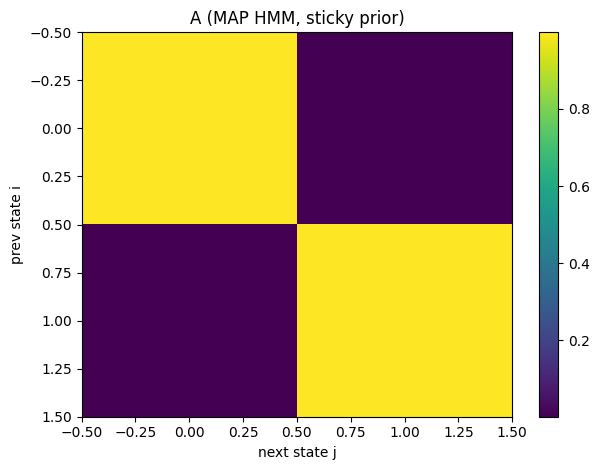

Implied expected durations (bars) — MLE: [819.46333521 976.23866202]
Implied expected durations (bars) — MAP: [ 871.55609452 1028.82431207]


In [42]:
def baum_welch_gaussian_diag_mapA(
    X: np.ndarray,
    K: int,
    n_iter: int,
    pi_init: np.ndarray,
    A_init: np.ndarray,
    mu_init: np.ndarray,
    var_init: np.ndarray,
    alpha_prior: np.ndarray,   # (K,K) Dirichlet params per row
    min_var: float = 1e-6,
    verbose: bool = True,
) -> Dict[str, np.ndarray]:
    pi = np.maximum(pi_init, 1e-12).astype(float)
    pi = pi / pi.sum()

    A = np.maximum(A_init, 1e-12).astype(float)
    A = A / A.sum(axis=1, keepdims=True)

    mu = mu_init.astype(float).copy()
    var = np.maximum(var_init.astype(float).copy(), min_var)

    loglik_hist = []

    for it in range(n_iter):
        log_pi = np.log(np.maximum(pi, 1e-12))
        log_A = np.log(np.maximum(A, 1e-12))
        logB = gaussian_diag_logpdf(X, mu, var)

        fb = forward_backward_log(log_pi, log_A, logB)
        gamma = fb["gamma"]
        xi_sum = fb["xi_sum"]
        loglik = float(fb["loglik"])
        loglik_hist.append(loglik)

        # M-step
        pi = np.maximum(gamma[0], 1e-12)
        pi = pi / pi.sum()

        # MAP update for A with Dirichlet prior
        A_num = xi_sum + (alpha_prior - 1.0)
        A_num = np.maximum(A_num, 1e-12)
        A = A_num / A_num.sum(axis=1, keepdims=True)

        # emission updates
        gamma_sum = gamma.sum(axis=0)
        mu = (gamma.T @ X) / gamma_sum[:, None]
        Ex2 = (gamma.T @ (X ** 2)) / gamma_sum[:, None]
        var = np.maximum(Ex2 - mu ** 2, min_var)

        if verbose and ((it == 0) or ((it + 1) % 5 == 0) or (it == n_iter - 1)):
            print(f"iter {it+1:02d}/{n_iter} | loglik={loglik:.3f}")

    return {"pi": pi, "A": A, "mu": mu, "var": var, "loglik_hist": np.array(loglik_hist)}


# Sticky prior: alpha = base + kappa*I
base = 1.0
kappa = 2000.0
alpha_prior = base * np.ones((K_HMM, K_HMM)) + kappa * np.eye(K_HMM)

params_map = baum_welch_gaussian_diag_mapA(
    X=X_bw,
    K=K_HMM,
    n_iter=25,
    pi_init=pi0,
    A_init=A0,
    mu_init=mu0,
    var_init=var0,
    alpha_prior=alpha_prior,
    verbose=True,
)

plot_transition_matrix(params["A"], "A (MLE HMM)")
plot_transition_matrix(params_map["A"], "A (MAP HMM, sticky prior)")

# Compare implied durations
dur_mle = 1.0 / (1.0 - np.diag(params["A"]))
dur_map = 1.0 / (1.0 - np.diag(params_map["A"]))
print("Implied expected durations (bars) — MLE:", dur_mle)
print("Implied expected durations (bars) — MAP:", dur_map)

Top 10 changepoint probabilities:


bar_time
2025-11-15 00:21:00+00:00    1.000000
2025-11-16 15:54:00+00:00    0.524708
2025-11-19 22:21:00+00:00    0.341836
2025-11-20 13:31:00+00:00    0.187610
2025-11-18 00:47:00+00:00    0.168058
2025-11-18 14:33:00+00:00    0.149624
2025-11-15 22:07:00+00:00    0.088927
2025-11-17 00:03:00+00:00    0.068286
2025-11-18 20:45:00+00:00    0.062745
2025-11-19 21:21:00+00:00    0.049373
Name: cp_prob, dtype: float64

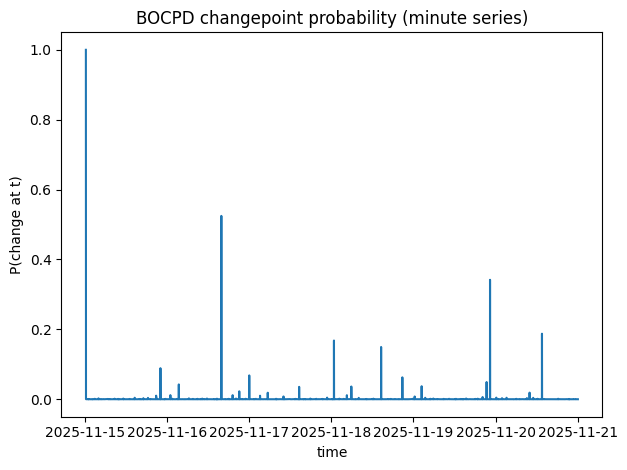

In [43]:
from scipy.special import gammaln

def student_t_logpdf(y: float, mu: float, scale: float, nu: float) -> float:
    # log pdf of Student-t with df=nu, location=mu, scale=scale
    z = (y - mu) / scale
    return (gammaln((nu + 1.0) / 2.0) - gammaln(nu / 2.0)
            - 0.5 * np.log(nu * np.pi) - np.log(scale)
            - ((nu + 1.0) / 2.0) * np.log1p((z ** 2) / nu))


@dataclass
class NIGParams:
    mu: float
    kappa: float
    alpha: float
    beta: float

def nig_update(p: NIGParams, y: float) -> NIGParams:
    # Conjugate update for Normal-Inverse-Gamma
    kappa_n = p.kappa + 1.0
    mu_n = (p.kappa * p.mu + y) / kappa_n
    alpha_n = p.alpha + 0.5
    beta_n = p.beta + 0.5 * (p.kappa * (y - p.mu) ** 2) / kappa_n
    return NIGParams(mu=mu_n, kappa=kappa_n, alpha=alpha_n, beta=beta_n)

def nig_pred_logpdf(p: NIGParams, y: float) -> float:
    # Student-t predictive under NIG
    nu = 2.0 * p.alpha
    scale2 = p.beta * (p.kappa + 1.0) / (p.alpha * p.kappa)
    scale = np.sqrt(max(scale2, 1e-12))
    return student_t_logpdf(y=y, mu=p.mu, scale=scale, nu=nu)

def bocpd(
    y: np.ndarray,
    hazard: float,
    prior: NIGParams,
    R_max: int = 500,
) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Returns:
      cp_prob[t] = P(r_t = 0 | y_1:t)  (changepoint prob at t)
      R[t,r] = run-length posterior (truncated to R_max)
    '''
    T = len(y)
    R = np.zeros((T, R_max + 1), dtype=np.float64)

    # Params for each run length r at time t-1
    params_r = [prior] + [None] * R_max

    # t=0 init
    _ = np.exp(nig_pred_logpdf(prior, y[0]))
    R[0, 0] = 1.0
    params_r[0] = nig_update(prior, y[0])

    cp_prob = np.zeros(T, dtype=np.float64)
    cp_prob[0] = 1.0

    for t in range(1, T):
        # predictive probs for existing run lengths
        pred = np.zeros(R_max + 1, dtype=np.float64)
        for r in range(R_max + 1):
            if params_r[r] is None:
                pred[r] = 0.0
            else:
                pred[r] = np.exp(nig_pred_logpdf(params_r[r], y[t]))

        # Growth
        growth = np.zeros(R_max + 1, dtype=np.float64)
        growth[1:] = R[t - 1, :-1] * (1.0 - hazard) * pred[:-1]

        # Changepoint
        cp = (R[t - 1, :] * hazard).sum() * np.exp(nig_pred_logpdf(prior, y[t]))
        R[t, 0] = cp
        R[t, 1:] = growth[1:]

        # Normalize
        Z = R[t].sum()
        if Z <= 0:
            R[t, 0] = 1.0
            Z = 1.0
        R[t] /= Z

        cp_prob[t] = R[t, 0]

        # Update params for next step
        new_params = [None] * (R_max + 1)
        new_params[0] = nig_update(prior, y[t])  # new run
        for r in range(1, R_max + 1):
            if params_r[r - 1] is not None:
                new_params[r] = nig_update(params_r[r - 1], y[t])
        params_r = new_params

    return cp_prob, R


# Build x_t = standardized log vol on minute bars (used by BOCPD)
eps = 1e-12
x_series = np.log(vol_min + eps).replace([np.inf, -np.inf], np.nan).dropna()

# Baseline for standardization: first 20% of series (choose a calm reference period if preferred)
n0 = max(100, int(0.2 * len(x_series)))
base = x_series.iloc[:n0]
x_std = (x_series - base.mean()) / (base.std() if base.std() > 0 else 1.0)

y = x_std.values.astype(float)

hazard_L = 240.0          # expected segment length ~ 240 minutes (4 hours)
hazard = 1.0 / hazard_L
prior = NIGParams(mu=0.0, kappa=1e-2, alpha=1.0, beta=1.0)

cp_prob, R = bocpd(y=y, hazard=hazard, prior=prior, R_max=500)

cp_series = pd.Series(cp_prob, index=x_std.index, name="cp_prob")
print("Top 10 changepoint probabilities:")
display(cp_series.sort_values(ascending=False).head(10))

# Plot change point probability on a short window
start = cp_series.index.min()
end = start + pd.Timedelta("7d")
cp_win = cp_series.loc[start:end]

plt.figure()
plt.plot(cp_win.index, cp_win.values)
plt.title("BOCPD changepoint probability (minute series)")
plt.xlabel("time")
plt.ylabel("P(change at t)")
plt.tight_layout()
plt.show()

# 10. Duration modeling: HSMM perspective and why it matters

A plain HMM implies geometric state durations (Section 2). Empirically, financial regimes can exhibit:

- long calm periods (opening/closing effects, steady liquidity),
- stressed episodes with heavy‑tailed durations,
- session structure and time‑of‑day effects.

The geometric distribution is memoryless:
$$
\mathbb{P}(D_i>d+k\mid D_i>d)=\mathbb{P}(D_i>k).
$$
This is rarely literally true.

A **Hidden Semi‑Markov Model (HSMM)** replaces self‑transition persistence with an explicit duration distribution $p_i(d)$.
Conceptually:

1. choose state $s$,
2. draw duration $D\sim p_s(\cdot)$,
3. emit $D$ observations under that state,
4. transition to a new state.

Full HSMM inference is more complex than HMM inference. Here we demonstrate the core idea by:

- estimating empirical durations from the HMM Viterbi path,
- using those durations in an HSMM‑style Viterbi decoding on a short subset.

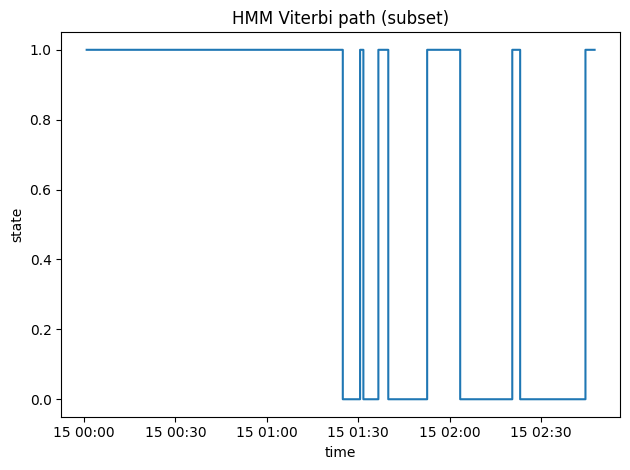

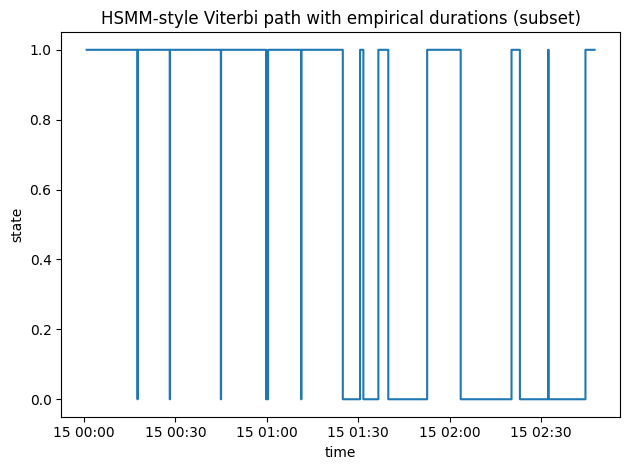

Subset agreement HMM vs HSMM: 0.99


In [44]:
def hsmm_viterbi_subset(
    log_pi: np.ndarray,
    A_full: np.ndarray,
    logB: np.ndarray,
    log_dur: np.ndarray,  # (K, D_max) for d=1..D_max
) -> np.ndarray:
    '''
    HSMM Viterbi decoding with explicit durations.
    Assumes:
      - durations handle persistence (so we zero the diagonal of A and renormalize off-diagonal transitions)
      - log_dur[k, d-1] = log P(duration=d | state=k)

    Returns a hard state path of length T.
    '''
    T, K = logB.shape
    D_max = log_dur.shape[1]

    # Off-diagonal transition matrix
    A_off = A_full.copy()
    np.fill_diagonal(A_off, 0.0)
    row_sums = A_off.sum(axis=1, keepdims=True)
    A_off = np.divide(A_off, row_sums, out=np.full_like(A_off, 1.0 / (K - 1)), where=row_sums > 0)
    log_Aoff = np.log(np.maximum(A_off, 1e-300))

    # cumulative sums of logB for fast segment likelihood sums
    cum = np.vstack([np.zeros((1, K)), np.cumsum(logB, axis=0)])  # cum[t] = sum logB[:t]

    def seg_ll(t0, t1, k):
        # inclusive segment likelihood sum logB[t0..t1,k]
        return cum[t1 + 1, k] - cum[t0, k]

    delta = np.full((T, K), -np.inf, dtype=np.float64)
    psi_prev_t = np.full((T, K), -1, dtype=np.int64)
    psi_prev_state = np.full((T, K), -1, dtype=np.int64)
    psi_dur = np.full((T, K), 1, dtype=np.int64)

    for t in range(T):
        d_max_here = min(D_max, t + 1)
        for j in range(K):
            best_score = -np.inf
            best_prev_t = -1
            best_prev_state = -1
            best_d = 1

            for d in range(1, d_max_here + 1):
                t0 = t - d + 1
                prev_t = t0 - 1

                seg = seg_ll(t0, t, j)
                score_dur = log_dur[j, d - 1]

                if prev_t < 0:
                    score = log_pi[j] + score_dur + seg
                    prev_state = -1
                else:
                    tmp = delta[prev_t] + log_Aoff[:, j]
                    i_star = int(np.argmax(tmp))
                    score = tmp[i_star] + score_dur + seg
                    prev_state = i_star

                if score > best_score:
                    best_score = score
                    best_prev_t = prev_t
                    best_prev_state = prev_state
                    best_d = d

            delta[t, j] = best_score
            psi_prev_t[t, j] = best_prev_t
            psi_prev_state[t, j] = best_prev_state
            psi_dur[t, j] = best_d

    # backtrack
    path = np.full(T, -1, dtype=np.int64)
    j = int(np.argmax(delta[T - 1]))
    t = T - 1
    while t >= 0 and j >= 0:
        d = int(psi_dur[t, j])
        t0 = t - d + 1
        path[t0:t + 1] = j
        prev_t = int(psi_prev_t[t, j])
        prev_state = int(psi_prev_state[t, j])
        t = prev_t
        j = prev_state

    return path


# Build empirical duration distributions from Viterbi (smoothed, capped)
D_max = 200
log_dur = np.zeros((K_HMM, D_max), dtype=np.float64)
for k in range(K_HMM):
    d = np.array(durations[k], dtype=int)
    d = d[d > 0]
    d = np.minimum(d, D_max)
    counts = np.bincount(d, minlength=D_max + 1)[1:]  # 1..D_max
    probs = (counts + 1.0) / (counts.sum() + D_max)   # add-1 smoothing
    log_dur[k] = np.log(probs)

# Run HSMM decoding on a small subset to keep it fast
T_sub = min(2000, len(feat))
logB_sub = logB_all[:T_sub]
path_hsmm = hsmm_viterbi_subset(log_pi, params["A"], logB_sub, log_dur)

# Compare with HMM Viterbi on same subset
path_hmm = v_path[:T_sub]
time_sub = feat.index[:T_sub]

plt.figure()
plt.plot(time_sub, path_hmm, drawstyle="steps-post")
plt.title("HMM Viterbi path (subset)")
plt.xlabel("time")
plt.ylabel("state")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(time_sub, path_hsmm, drawstyle="steps-post")
plt.title("HSMM-style Viterbi path with empirical durations (subset)")
plt.xlabel("time")
plt.ylabel("state")
plt.tight_layout()
plt.show()

print("Subset agreement HMM vs HSMM:", (path_hmm == path_hsmm).mean())

# 11. Covariate-driven switching: a pragmatic diagnostic

In many finance settings, regime persistence is not constant. It depends on exogenous or contemporaneous variables:

- macro announcements,
- funding rates and open interest (crypto),
- liquidity measures,
- volatility itself.

A time‑varying transition probability (TVTP) HMM replaces fixed $A$ with:
$$
\mathbb{P}(s_t=j\mid s_{t-1}=i, z_{t-1})
=
\frac{\exp(\eta_{ij}^\top z_{t-1})}{\sum_{\ell=0}^{K-1}\exp(\eta_{i\ell}^\top z_{t-1})}.
$$
Full estimation requires extending EM because transitions enter nonlinearly.

Diagnostic approach used here. We adopt a reduced‑form, state‑conditional switching model:

1. Use the filtered HMM probabilities to produce a causal state label (argmax of $p(s_t\mid x_{1:t})$).
2. Define a “switch” event $\mathbb{I}\{s_{t+1}\neq s_t\}$.
3. Fit a logistic regression for each current state:
$$
   \mathbb{P}(\text{switch at }t\mid s_t=i, z_t)=\sigma(\beta_i^\top z_t).
$$

This is not a full TVTP‑HMM, but it answers a practical question:
which covariates are associated with instability within each regime?

Importantly, we standardize covariates using training‑period statistics only and train the logistic models on the training period only (to avoid implicit look‑ahead).


Causal switching diagnostic: filtered states + train-period standardization

State 0: logistic model for switch probability (trained on first 70%)


,log_depth,imbalance,log_spread,log_intensity,log_rv
coef,-0.322531,-0.292397,0.927631,2.615601,2.85852


Intercept: -5.9024342869009185

State 1: logistic model for switch probability (trained on first 70%)


/var/folders/r3/hk9qq_td10l_xnrsz1qm58jr0000gn/T/ipykernel_34481/460397957.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Intercept:", float(clf.intercept_))


,log_spread,log_intensity,log_depth,log_rv,imbalance
coef,-6.856766,-1.161721,-0.111257,-0.00078,0.128721


Intercept: -6.17812799299884


/var/folders/r3/hk9qq_td10l_xnrsz1qm58jr0000gn/T/ipykernel_34481/460397957.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Intercept:", float(clf.intercept_))


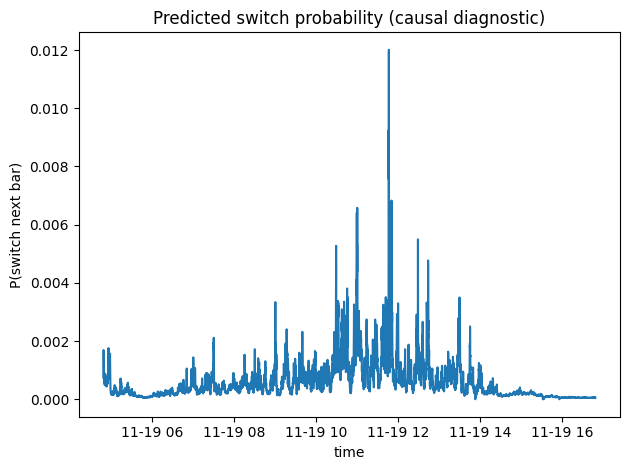


Mean switch probability by state (TEST period):


state
1    0.000642
Name: p_switch, dtype: float64

In [45]:
print("\n" + "="*70)
print("Causal switching diagnostic: filtered states + train-period standardization")
print("="*70)

# Use argmax of filtered probabilities (causal, though noisy)
state_filt = np.argmax(fb_all["filt"], axis=1)

# Time-ordered train/test split (same as used for HMM fitting)
split_idx = int(0.7 * len(feat))
feat_causal = feat.copy()

# Covariates used for the switching model
cov_cols = ["log_spread", "log_depth", "log_intensity", "imbalance", "log_rv"]

# Standardize using TRAINING statistics only
Z_all = feat_causal[cov_cols].values
Z_train_stats = Z_all[:split_idx]
z_mu = Z_train_stats.mean(axis=0, keepdims=True)
z_sd = Z_train_stats.std(axis=0, keepdims=True) + 1e-12

Z_std_causal = (Z_all - z_mu) / z_sd
Z_std_causal = Z_std_causal[:-1]  # align with transitions

# Build transition labels from filtered states
cur_state_filt = state_filt[:-1]
next_state_filt = state_filt[1:]
y_switch_filt = (next_state_filt != cur_state_filt).astype(int)

# Train on the training period only
train_mask = np.arange(len(cur_state_filt)) < (split_idx - 1)

models_causal = {}
for i in range(K_HMM):
    state_mask = (cur_state_filt == i) & train_mask
    Xi = Z_std_causal[state_mask]
    yi = y_switch_filt[state_mask]

    if yi.sum() < 20:
        print(f"State {i}: too few switches ({int(yi.sum())}) in training set.")
        continue

    clf = LogisticRegression(max_iter=2000)
    clf.fit(Xi, yi)
    models_causal[i] = clf
    coef = pd.Series(clf.coef_[0], index=cov_cols).sort_values()
    print(f"\nState {i}: logistic model for switch probability (trained on first 70%)")
    display(coef.to_frame("coef").T)
    print("Intercept:", float(clf.intercept_))

# Compute switch probabilities for the full sample (model trained only on train set)
p_switch_causal = np.full(len(cur_state_filt), np.nan, dtype=float)
for i, clf in models_causal.items():
    mask = (cur_state_filt == i)
    p_switch_causal[mask] = clf.predict_proba(Z_std_causal[mask])[:, 1]

p_switch_series_causal = pd.Series(p_switch_causal, index=feat.index[:-1], name="p_switch_causal")

# Plot on a test window (out-of-sample)
test_start = feat.index[split_idx]
test_end = test_start + pd.Timedelta("12h")
win_causal = p_switch_series_causal.loc[test_start:test_end]

plt.figure()
plt.plot(win_causal.index, win_causal.values)
plt.title("Predicted switch probability (causal diagnostic)")
plt.xlabel("time")
plt.ylabel("P(switch next bar)")
plt.tight_layout()
plt.show()

# Interpretation helper: compare average p_switch in each state (test period only)
test_mask_full = np.arange(len(cur_state_filt)) >= (split_idx - 1)
tmp_causal = pd.DataFrame({
    "state": cur_state_filt[test_mask_full],
    "p_switch": p_switch_causal[test_mask_full]
})
print("\nMean switch probability by state (TEST period):")
display(tmp_causal.groupby("state")["p_switch"].mean())

# 12. Finance applications using quotes‑only regimes

With quotes‑only data, the most robust uses of regimes are risk and execution diagnostics, not full P&L attribution.

Nevertheless, regimes inferred from volatility and liquidity features can support volatility regime classification for risk scaling, dtress gating (reduce activity when stress probability is high), regime‑conditioned forecasting diagnostics, etcetera.

## 12.1 Mapping latent states to economic interpretation

With Gaussian emissions, state means provide an interpretable summary in feature space. We identify:

- a “high volatility” state via $\log(rv)$,
- a “wide spread” state via $\log(1+\text{spread})$,
- a “low depth” state via $\log(\text{depth})$.

## 12.2 An illustrative risk‑scaling rule (filtered probabilities; causal)

A common risk control idea is to reduce exposure when the probability of a stress regime rises.
Using the filtered (causal) probability:
$$
\text{exposure}_{t} = 1 - \mathbb{P}(s_{t-1}=\text{high-vol}\mid x_{1:t-1}).
$$

The one‑bar lag is essential: exposure applied to return $r_t$ must be computed from information available before observing bar $t$.

,log_rv,log_spread,imbalance,log_depth,log_intensity
0,-9.075388,0.010392,0.023472,2.087263,4.097697
1,-8.381241,0.010742,0.004239,2.041222,4.374125


High-vol state: 1
Wide-spread state: 1
Low-depth state: 1


,log_rv,log_spread,imbalance,log_depth,log_intensity
0,-9.075388,0.010392,0.023472,2.087329,4.097697
1,-8.439609,0.010972,0.003668,2.165627,4.366062


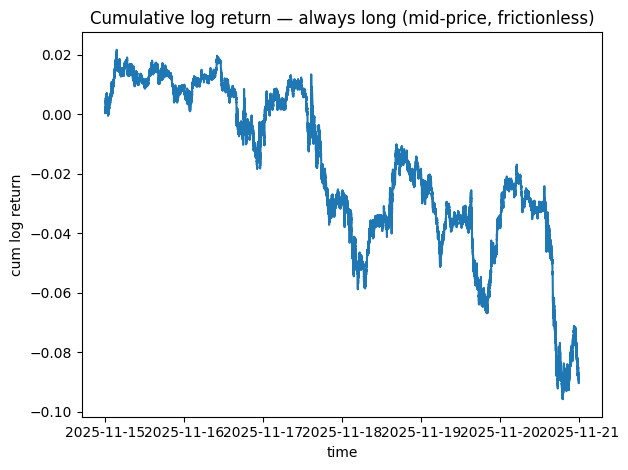

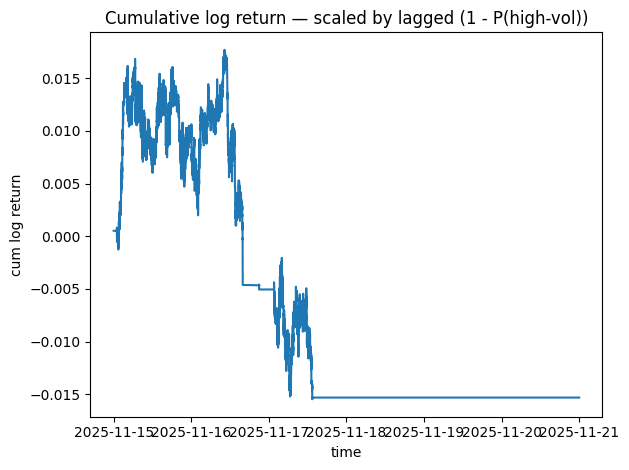

Std of returns (raw): 0.0002275253141745759
Std of returns (scaled, lagged exposure): 7.403806758320705e-05


In [ ]:
# Identify which HMM state looks like "high vol" and/or "illiquid"
mu_orig = mu_state_orig.copy()
display(mu_orig)

high_vol_state = int(mu_orig["log_rv"].values.argmax())
wide_spread_state = int(mu_orig["log_spread"].values.argmax())
low_depth_state = int(mu_orig["log_depth"].values.argmin())

print("High-vol state:", high_vol_state)
print("Wide-spread state:", wide_spread_state)
print("Low-depth state:", low_depth_state)

# Regime probabilities (filtered = causal)
p_high_vol = fb_all["filt"][:, high_vol_state]
p_wide_spread = fb_all["filt"][:, wide_spread_state]

p_high_vol_s = pd.Series(p_high_vol, index=feat.index, name="p_high_vol")

# Regime-conditioned stats using smoothed gamma (useful for segmentation, not causal)
gamma = fb_all["gamma"]
weights = gamma / gamma.sum(axis=0, keepdims=True)

feat_vals = feat.values
means_by_state = {}
for k in range(K_HMM):
    w = gamma[:, k]
    w = w / w.sum()
    means_by_state[k] = (w[:, None] * feat_vals).sum(axis=0)

means_by_state = pd.DataFrame.from_dict(means_by_state, orient="index", columns=feat.columns)
display(means_by_state)

# -----------------------------
# Illustrative risk scaling example
# -----------------------------
# Use mid log returns at the HMM bar frequency aligned to feat index
r = bars_hmm.loc[feat.index, "r"].fillna(0.0)

# Baseline: always long 1 unit (frictionless)
pnl_raw = r

exposure_raw = 1.0 - p_high_vol_s
exposure_to_apply = exposure_raw.shift(1).fillna(1.0)
pnl_scaled = r * exposure_to_apply

# Cumulative log-return curves
cum_raw = pnl_raw.cumsum()
cum_scaled = pnl_scaled.cumsum()

plt.figure()
plt.plot(cum_raw.index, cum_raw.values)
plt.title("Cumulative log return — always long (mid-price, frictionless)")
plt.xlabel("time")
plt.ylabel("cum log return")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(cum_scaled.index, cum_scaled.values)
plt.title("Cumulative log return — scaled by lagged (1 - P(high-vol))")
plt.xlabel("time")
plt.ylabel("cum log return")
plt.tight_layout()
plt.show()

print("Std of returns (raw):", float(pnl_raw.std()))
print("Std of returns (scaled, lagged exposure):", float(pnl_scaled.std()))